In [1]:
import pandas as pd
from pathlib import Path

pd.set_option("display.max_columns", 10)

base = Path("data/clean_classifier_data")

# ----- FILE REGISTRY -----
parquet_files = {
    "atac_pseudobulk_df": base / "clean_data_files/atac_pseudobulk_df.parquet",
    "rna_pseudobulk_df":  base / "clean_data_files/rna_pseudobulk_df.parquet",
    "peak_to_gene_dist_df": base / "clean_feature_files/peak_to_gene_dist_df.parquet",
    "sliding_window_df":    base / "clean_feature_files/sliding_window_df.parquet",
    "cicero_df":           base / "clean_feature_files/cicero_df.parquet",
    "old_sliding_window_df": base / "clean_feature_files/old_sliding_window_df.parquet",
    "homer_df":            base / "clean_feature_files/homer_df.parquet",
}

csv_files = {
    "bear_no_beeline_df":              base / "clean_ground_truth_files/bear_no_beeline_df.csv",
    "bear_no_beeline_or_chip_df":      base / "clean_ground_truth_files/bear_no_beeline_or_chip_df.csv",
    "bear_no_chip_df":                 base / "clean_ground_truth_files/bear_no_chip_df.csv",
    "beeline_no_bear_df":              base / "clean_ground_truth_files/beeline_no_bear_df.csv",
    "beeline_no_chip_df":              base / "clean_ground_truth_files/beeline_no_chip_df.csv",
    "beeline_no_chip_or_bear_df":      base / "clean_ground_truth_files/beeline_no_chip_or_bear_df.csv",
    "chip_no_beeline_df":              base / "clean_ground_truth_files/chip_no_beeline_df.csv",
    "chip_no_beeline_or_bear_df":      base / "clean_ground_truth_files/chip_no_beeline_or_bear_df.csv",
    "chip_no_bear_df":                 base / "clean_ground_truth_files/chip_no_bear_df.csv",
}

# ----- LOAD DATA -----
dfs = {}
for name, path in parquet_files.items():
    dfs[name] = pd.read_parquet(path)
for name, path in csv_files.items():
    dfs[name] = pd.read_csv(path)

# ----- LOG HEADS & SHAPES -----
for name, df in dfs.items():
    print(f"\n{name}")
    print(df.head(3))
    print(df.shape)



atac_pseudobulk_df
                      E7.5_REP1.AAACAGCCAAACCCTA  E7.5_REP1.AAACAGCCAGGAACTG  \
peak_id                                                                        
chr1:3142536-3143136                    0.093238                    0.000000   
chr1:3553099-3553699                    0.035439                    0.199449   
chr1:3584996-3585596                    0.000000                    0.000000   

                      E7.5_REP1.AAACAGCCATCCTGAA  E7.5_REP1.AAACAGCCATGCTATG  \
peak_id                                                                        
chr1:3142536-3143136                         0.0                    0.040567   
chr1:3553099-3553699                         0.0                    0.360751   
chr1:3584996-3585596                         0.0                    0.000000   

                      E7.5_REP1.AAACATGCAATGAATG  ...  \
peak_id                                           ...   
chr1:3142536-3143136                    0.000000  ...   
chr1:35

In [2]:
import numpy as np
import pandas as pd
from numba import jit
from scipy.stats import pearsonr, spearmanr
from scipy.special import rel_entr
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import warnings
from tqdm.auto import tqdm
warnings.filterwarnings('ignore')

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def safe_divide(a, b, fill_value=0.0):
    """Safe division with fill value for division by zero."""
    return np.divide(a, b, out=np.full_like(a, fill_value, dtype=float), where=b!=0)

def entropy(x):
    """Calculate Shannon entropy of array x."""
    x = x[x > 0]  # Remove zeros
    if len(x) == 0:
        return 0.0
    p = x / np.sum(x)
    return -np.sum(p * np.log2(p))

def partial_correlation(x, y, z):
    """Calculate partial correlation between x and y controlling for z."""
    if len(x) < 3:
        return np.nan
    try:
        # Residuals after regressing out z
        x_resid = x - np.mean(x)
        y_resid = y - np.mean(y)
        z_norm = (z - np.mean(z)) / (np.std(z) + 1e-10)
        
        x_resid = x_resid - np.dot(x_resid, z_norm) * z_norm / (np.dot(z_norm, z_norm) + 1e-10)
        y_resid = y_resid - np.dot(y_resid, z_norm) * z_norm / (np.dot(z_norm, z_norm) + 1e-10)
        
        # Correlation of residuals
        corr = np.corrcoef(x_resid, y_resid)[0, 1]
        return corr if not np.isnan(corr) else 0.0
    except:
        return np.nan

@jit(nopython=True)
def fast_gini(x):
    """Numba-compiled Gini coefficient."""
    if len(x) == 0 or np.sum(x) == 0:
        return 0.0
    sorted_x = np.sort(x)
    n = len(x)
    cumsum = np.cumsum(sorted_x)
    return (2 * np.sum((n - np.arange(n)) * sorted_x)) / (n * cumsum[-1]) - (n + 1) / n

@jit(nopython=True)
def fast_entropy(x):
    """Numba-compiled Shannon entropy."""
    x_pos = x[x > 0]
    if len(x_pos) == 0:
        return 0.0
    p = x_pos / np.sum(x_pos)
    return -np.sum(p * np.log2(p))

@jit(nopython=True)
def compute_distance_features(scores, tss_scores, tss_distances):
    """Numba-compiled distance feature computation."""
    n = len(scores)
    
    # Initialize outputs
    min_tss_dist = np.inf
    mean_tss_dist = np.inf
    closest_peak_binding = 0.0
    peaks_1kb = 0
    peaks_5kb = 0
    peaks_10kb = 0
    peaks_50kb = 0
    
    abs_distances = np.abs(tss_distances)
    binding_mask = scores > 0
    
    if np.sum(binding_mask) > 0:
        bound_distances = abs_distances[binding_mask]
        bound_scores = scores[binding_mask]
        
        min_tss_dist = np.min(bound_distances)
        closest_idx = np.argmin(bound_distances)
        closest_peak_binding = bound_scores[closest_idx]
        
        # Weighted mean distance
        mean_tss_dist = np.sum(bound_distances * bound_scores) / np.sum(bound_scores)
        
        # Binned counts
        peaks_1kb = np.sum((abs_distances < 1000) & binding_mask)
        peaks_5kb = np.sum((abs_distances < 5000) & binding_mask)
        peaks_10kb = np.sum((abs_distances < 10000) & binding_mask)
        peaks_50kb = np.sum((abs_distances < 50000) & binding_mask)
    
    return min_tss_dist, mean_tss_dist, closest_peak_binding, peaks_1kb, peaks_5kb, peaks_10kb, peaks_50kb

# ============================================================================
# PRECOMPUTE CORRELATION MATRICES (ONE-TIME COMPUTATION)
# ============================================================================

def precompute_correlation_matrices(rna_df, atac_df, peak_to_gene_df):
    """
    Pre-compute correlation matrices to avoid redundant calculations.
    Fully vectorized for maximum speed.
    """
    print("Pre-computing correlation matrices...")
    
    # Get unique genes and TFs
    genes = peak_to_gene_df['TG'].unique()
    tfs = rna_df.index.tolist()
    
    # ========================================================================
    # 1. GENE ACCESSIBILITY (sum of peaks per gene)
    # ========================================================================
    print("\n[1/4] Computing gene accessibility...")
    gene_to_peaks = peak_to_gene_df.groupby('TG')['peak_id'].apply(list).to_dict()
    
    gene_accessibility_dict = {}
    for gene in tqdm(genes, desc="  Gene accessibility"):
        if gene in gene_to_peaks:
            peaks = gene_to_peaks[gene]
            valid_peaks = [p for p in peaks if p in atac_df.index]
            if valid_peaks:
                gene_accessibility_dict[gene] = atac_df.loc[valid_peaks].sum(axis=0).values
            else:
                gene_accessibility_dict[gene] = np.zeros(atac_df.shape[1])
        else:
            gene_accessibility_dict[gene] = np.zeros(atac_df.shape[1])
    
    # ========================================================================
    # 2. TF-TG EXPRESSION CORRELATIONS (Vectorized)
    # ========================================================================
    print("\n[2/4] Computing TF-TG expression correlations...")
    
    # Get subset of RNA matrix for genes of interest
    genes_in_rna = [g for g in genes if g in rna_df.index]
    tfs_in_rna = [tf for tf in tfs if tf in rna_df.index]
    
    # Create index mappings for fast lookup
    rna_gene_to_idx = {gene: idx for idx, gene in enumerate(rna_df.index)}
    
    # Extract TF and gene expression matrices
    tf_indices = [rna_gene_to_idx[tf] for tf in tfs_in_rna]
    gene_indices = [rna_gene_to_idx[g] for g in genes_in_rna]
    
    tf_matrix = rna_df.values[tf_indices, :]  # (n_tfs, n_cells)
    gene_matrix = rna_df.values[gene_indices, :]  # (n_genes, n_cells)
    
    # Compute Pearson correlation matrix all at once
    print("  Computing Pearson correlations (vectorized)...")
    # Pearson: use numpy corrcoef on stacked arrays, then extract submatrix
    # More memory efficient: compute in chunks if needed
    
    tf_tg_corr_pearson = {}
    tf_tg_corr_spearman = {}
    
    # Use pandas for efficient correlation computation
    tf_df = pd.DataFrame(tf_matrix, index=tfs_in_rna)
    gene_df = pd.DataFrame(gene_matrix, index=genes_in_rna)
    
    # Compute full correlation matrix (TFs x Genes)
    # This is much faster than nested loops
    pearson_corr_matrix = np.corrcoef(tf_matrix, gene_matrix)[:len(tfs_in_rna), len(tfs_in_rna):]
    
    # Store in dictionary
    for i, tf in enumerate(tqdm(tfs_in_rna, desc="  Storing Pearson")):
        for j, gene in enumerate(genes_in_rna):
            corr_val = pearson_corr_matrix[i, j]
            tf_tg_corr_pearson[(tf, gene)] = corr_val if not np.isnan(corr_val) else 0.0
    
    # Compute Spearman (on ranks) - this is slower, so we can do in batches
    print("  Computing Spearman correlations (vectorized)...")
    
    # Rank transform the matrices
    from scipy.stats import rankdata
    tf_ranks = np.apply_along_axis(rankdata, 1, tf_matrix)
    gene_ranks = np.apply_along_axis(rankdata, 1, gene_matrix)
    
    # Compute correlation on ranks (Spearman)
    spearman_corr_matrix = np.corrcoef(tf_ranks, gene_ranks)[:len(tfs_in_rna), len(tfs_in_rna):]
    
    for i, tf in enumerate(tqdm(tfs_in_rna, desc="  Storing Spearman")):
        for j, gene in enumerate(genes_in_rna):
            corr_val = spearman_corr_matrix[i, j]
            tf_tg_corr_spearman[(tf, gene)] = corr_val if not np.isnan(corr_val) else 0.0
    
    # ========================================================================
    # 3. TF-ACCESSIBILITY CORRELATIONS (Vectorized)
    # ========================================================================
    print("\n[3/4] Computing TF-accessibility correlations...")
    
    # Create gene accessibility matrix
    gene_acc_matrix = np.array([gene_accessibility_dict[g] for g in genes])  # (n_genes, n_cells)
    
    # Compute correlation between TFs and gene accessibility
    tf_atac_corr_matrix = np.corrcoef(tf_matrix, gene_acc_matrix)[:len(tfs_in_rna), len(tfs_in_rna):]
    
    tf_atac_corr = {}
    for i, tf in enumerate(tqdm(tfs_in_rna, desc="  TF-accessibility")):
        for j, gene in enumerate(genes):
            corr_val = tf_atac_corr_matrix[i, j]
            tf_atac_corr[(tf, gene)] = corr_val if not np.isnan(corr_val) else 0.0
    
    # ========================================================================
    # 4. TG EXPRESSION-ACCESSIBILITY CORRELATIONS (Vectorized)
    # ========================================================================
    print("\n[4/4] Computing TG expression-accessibility correlations...")
    
    atac_rna_corr = {}
    
    # For each gene, compute correlation between its expression and accessibility
    for i, gene in enumerate(tqdm(genes, desc="  Gene expr-accessibility")):
        if gene in genes_in_rna:
            gene_idx = gene_indices[genes_in_rna.index(gene)]
            tg_expr = rna_df.values[gene_idx, :]
            gene_acc = gene_accessibility_dict[gene]
            
            corr = np.corrcoef(tg_expr, gene_acc)[0, 1]
            atac_rna_corr[gene] = corr if not np.isnan(corr) else 0.0
        else:
            atac_rna_corr[gene] = 0.0
    
    print("\n✓ Correlation matrices computed!\n")
    
    return {
        'tf_tg_corr_pearson': tf_tg_corr_pearson,
        'tf_tg_corr_spearman': tf_tg_corr_spearman,
        'tf_atac_corr': tf_atac_corr,
        'atac_rna_corr': atac_rna_corr,
        'gene_accessibility_dict': gene_accessibility_dict
    }

# ============================================================================
# MAIN FEATURE COMPUTATION
# ============================================================================

def compute_binding_features_fast(tf_tg_binding):
    """
    Fast vectorized computation of binding features.
    Uses groupby with built-in aggregations + custom numba functions.
    """
    print("Computing binding features (vectorized)...")
    
    # Pre-compute weighted scores
    tf_tg_binding['weighted_score'] = (
        tf_tg_binding['sliding_window_score'] * tf_tg_binding['tss_distance_score']
    )
    tf_tg_binding['abs_tss_distance'] = np.abs(tf_tg_binding['tss_distance'])
    tf_tg_binding['has_binding'] = (tf_tg_binding['sliding_window_score'] > 0).astype(int)
    
    # Proximity score (exponential decay)
    tf_tg_binding['proximity_score'] = (
        tf_tg_binding['sliding_window_score'] * 
        np.exp(-tf_tg_binding['abs_tss_distance'] / 1000)
    )
    
    # Binned distance indicators
    tf_tg_binding['within_1kb'] = (
        (tf_tg_binding['abs_tss_distance'] < 1000) & 
        (tf_tg_binding['sliding_window_score'] > 0)
    ).astype(int)
    tf_tg_binding['within_5kb'] = (
        (tf_tg_binding['abs_tss_distance'] < 5000) & 
        (tf_tg_binding['sliding_window_score'] > 0)
    ).astype(int)
    tf_tg_binding['within_10kb'] = (
        (tf_tg_binding['abs_tss_distance'] < 10000) & 
        (tf_tg_binding['sliding_window_score'] > 0)
    ).astype(int)
    tf_tg_binding['within_50kb'] = (
        (tf_tg_binding['abs_tss_distance'] < 50000) & 
        (tf_tg_binding['sliding_window_score'] > 0)
    ).astype(int)
    
    # ========================================================================
    # FAST AGGREGATION (built-in functions)
    # ========================================================================
    print("  Phase 1: Basic aggregations...")
    
    agg_dict = {
        'sliding_window_score': [
            ('max_binding_score', 'max'),
            ('mean_binding_score', 'mean'),
            ('median_binding_score', 'median'),
            ('std_binding_score', 'std'),
            ('sum_binding_score', 'sum'),
        ],
        'weighted_score': [
            ('distance_weighted_binding', 'sum'),
            ('max_weighted_binding', 'max'),
        ],
        'has_binding': [
            ('n_peaks_with_binding', 'sum'),
        ],
        'proximity_score': [
            ('proximity_binding_score', 'sum'),
        ],
        'within_1kb': [('peaks_within_1kb', 'sum')],
        'within_5kb': [('peaks_within_5kb', 'sum')],
        'within_10kb': [('peaks_within_10kb', 'sum')],
        'within_50kb': [('peaks_within_50kb', 'sum')],
    }
    
    # This is MUCH faster than apply()
    features = tf_tg_binding.groupby(['TF', 'TG'], observed=True).agg(**{
        name: (col, func) for col, funcs in agg_dict.items() for name, func in funcs
    })
    
    # Add fraction peaks bound
    peak_counts = tf_tg_binding.groupby(['TF', 'TG'], observed=True).size()
    features['fraction_peaks_bound'] = features['n_peaks_with_binding'] / peak_counts
    
    # Compute 75th percentile threshold and strong peaks count
    print("  Phase 2: Strong peaks (75th percentile)...")
    percentile_75 = tf_tg_binding.groupby(['TF', 'TG'], observed=True)['sliding_window_score'].quantile(0.75)
    
    # Count peaks above 75th percentile
    tf_tg_binding_with_p75 = tf_tg_binding.merge(
        percentile_75.rename('p75'),
        left_on=['TF', 'TG'],
        right_index=True
    )
    tf_tg_binding_with_p75['is_strong'] = (
        tf_tg_binding_with_p75['sliding_window_score'] > tf_tg_binding_with_p75['p75']
    ).astype(int)
    
    n_strong_peaks = tf_tg_binding_with_p75.groupby(['TF', 'TG'], observed=True)['is_strong'].sum()
    features['n_strong_peaks'] = n_strong_peaks
    
    # ========================================================================
    # DISTANCE FEATURES (using numba for speed)
    # ========================================================================
    print("  Phase 3: Distance features (numba-accelerated)...")
    
    # Group data for numba processing
    grouped = tf_tg_binding.groupby(['TF', 'TG'], observed=True)
    
    distance_results = []
    for (tf, tg), group in tqdm(grouped, desc="    Distance features"):
        scores = group['sliding_window_score'].values
        tss_scores = group['tss_distance_score'].values
        tss_distances = group['tss_distance'].values
        
        min_dist, mean_dist, closest_binding, p1kb, p5kb, p10kb, p50kb = compute_distance_features(
            scores, tss_scores, tss_distances
        )
        
        distance_results.append({
            'TF': tf,
            'TG': tg,
            'min_tss_distance': min_dist,
            'mean_tss_distance': mean_dist,
            'closest_peak_binding': closest_binding,
            'peaks_within_1kb_check': p1kb,
            'peaks_within_5kb_check': p5kb,
            'peaks_within_10kb_check': p10kb,
            'peaks_within_50kb_check': p50kb,
        })
    
    distance_df = pd.DataFrame(distance_results).set_index(['TF', 'TG'])
    
    # Merge distance features
    features = features.join(distance_df)
    
    # Use the numba-computed binned counts (they should match the vectorized ones, but numba is more accurate)
    features['peaks_within_1kb'] = features['peaks_within_1kb_check']
    features['peaks_within_5kb'] = features['peaks_within_5kb_check']
    features['peaks_within_10kb'] = features['peaks_within_10kb_check']
    features['peaks_within_50kb'] = features['peaks_within_50kb_check']
    features.drop(columns=['peaks_within_1kb_check', 'peaks_within_5kb_check', 
                           'peaks_within_10kb_check', 'peaks_within_50kb_check'], inplace=True)
    
    # ========================================================================
    # ENTROPY AND GINI (using numba)
    # ========================================================================
    print("  Phase 4: Entropy and Gini (numba-accelerated)...")
    
    entropy_results = []
    for (tf, tg), group in tqdm(grouped, desc="    Entropy/Gini"):
        scores = group['sliding_window_score'].values
        
        entropy_val = fast_entropy(scores)
        gini_val = fast_gini(scores)
        
        entropy_results.append({
            'TF': tf,
            'TG': tg,
            'binding_entropy': entropy_val,
            'binding_gini': gini_val,
        })
    
    entropy_df = pd.DataFrame(entropy_results).set_index(['TF', 'TG'])
    features = features.join(entropy_df)
    
    # ========================================================================
    # NEGATIVE EVIDENCE
    # ========================================================================
    features['no_binding_near_tss'] = (features['peaks_within_10kb'] == 0).astype(int)
    
    # Reset index
    features = features.reset_index()
    
    print(f"✓ Computed binding features for {len(features)} TF-TG pairs\n")
    
    return features

def add_expression_features(features_df, rna_df, precomputed):
    """Add expression-based features (fully vectorized)."""
    print("Adding expression features...")
    
    rna_genes = rna_df.index.tolist()
    rna_matrix = rna_df.values
    
    # Create gene -> index mapping once
    rna_gene_to_idx = {gene: idx for idx, gene in enumerate(rna_genes)}
    
    # ========================================================================
    # PRE-COMPUTE ALL STATISTICS FOR ALL GENES (vectorized)
    # ========================================================================
    print("  Pre-computing gene statistics...")
    
    gene_stats = {}
    for idx, gene in enumerate(tqdm(rna_genes, desc="    Gene stats")):
        expr = rna_matrix[idx]
        mean_val = np.mean(expr)
        
        gene_stats[gene] = {
            'mean': mean_val,
            'std': np.std(expr),
            'cv': np.std(expr) / (mean_val + 1e-10),
            'detection_rate': np.mean(expr > 0),
            'p25': np.percentile(expr, 25) if mean_val > 0 else 0,
            'p75': np.percentile(expr, 75),
            'expr': expr,  # Store for context features
        }
    
    # ========================================================================
    # VECTORIZED FEATURE EXTRACTION
    # ========================================================================
    print("  Extracting features...")
    
    tf_list = features_df['TF'].values
    tg_list = features_df['TG'].values
    n_pairs = len(features_df)
    
    # Initialize all arrays
    tf_mean_expr = np.zeros(n_pairs)
    tf_std_expr = np.zeros(n_pairs)
    tf_cv = np.zeros(n_pairs)
    tf_detection_rate = np.zeros(n_pairs)
    
    tg_mean_expr = np.zeros(n_pairs)
    tg_std_expr = np.zeros(n_pairs)
    tg_cv = np.zeros(n_pairs)
    tg_detection_rate = np.zeros(n_pairs)
    
    tf_tg_expr_ratio = np.zeros(n_pairs)
    codetection_rate = np.zeros(n_pairs)
    
    tf_tg_pearson_corr = np.zeros(n_pairs)
    tf_tg_spearman_corr = np.zeros(n_pairs)
    
    tf_active_when_tg_active = np.zeros(n_pairs)
    tg_expr_in_top_tf_quartile = np.zeros(n_pairs)
    tg_expr_in_bottom_tf_quartile = np.zeros(n_pairs)
    differential_tg_expr = np.zeros(n_pairs)
    
    tf_not_expressed = np.zeros(n_pairs)
    anticorrelation_flag = np.zeros(n_pairs)
    
    # Process in batches for better progress tracking
    batch_size = 10000
    n_batches = (n_pairs + batch_size - 1) // batch_size
    
    for batch_idx in tqdm(range(n_batches), desc="  Processing batches"):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, n_pairs)
        
        for i in range(start_idx, end_idx):
            tf = tf_list[i]
            tg = tg_list[i]
            
            # TF features
            if tf in gene_stats:
                tf_stats = gene_stats[tf]
                tf_mean_expr[i] = tf_stats['mean']
                tf_std_expr[i] = tf_stats['std']
                tf_cv[i] = tf_stats['cv']
                tf_detection_rate[i] = tf_stats['detection_rate']
                
                tf_threshold = tf_stats['p25']
                tf_not_expressed[i] = 1 if tf_stats['mean'] < tf_threshold else 0
                
                tf_expr = tf_stats['expr']
                tf_75 = tf_stats['p75']
                tf_25 = tf_stats['p25']
            else:
                tf_expr = None
                tf_not_expressed[i] = 1
            
            # TG features
            if tg in gene_stats:
                tg_stats = gene_stats[tg]
                tg_mean_expr[i] = tg_stats['mean']
                tg_std_expr[i] = tg_stats['std']
                tg_cv[i] = tg_stats['cv']
                tg_detection_rate[i] = tg_stats['detection_rate']
                
                tg_threshold = tg_stats['p25']
                tg_expr_arr = tg_stats['expr']
            else:
                tg_expr_arr = None
            
            # TF-TG relationship features
            if tf_expr is not None and tg_expr_arr is not None:
                tf_tg_expr_ratio[i] = tf_mean_expr[i] / (tg_mean_expr[i] + 1e-10)
                codetection_rate[i] = np.mean((tf_expr > 0) & (tg_expr_arr > 0))
                
                # Get precomputed correlations
                tf_tg_pearson_corr[i] = precomputed['tf_tg_corr_pearson'].get((tf, tg), 0.0)
                tf_tg_spearman_corr[i] = precomputed['tf_tg_corr_spearman'].get((tf, tg), 0.0)
                
                # Context-aware features
                tg_active_mask = tg_expr_arr > tg_threshold
                if np.any(tg_active_mask):
                    tf_active_when_tg_active[i] = np.mean(tf_expr[tg_active_mask])
                
                tf_top_mask = tf_expr > tf_75
                tf_bottom_mask = tf_expr < tf_25
                
                if np.any(tf_top_mask):
                    tg_expr_in_top_tf_quartile[i] = np.mean(tg_expr_arr[tf_top_mask])
                if np.any(tf_bottom_mask):
                    tg_expr_in_bottom_tf_quartile[i] = np.mean(tg_expr_arr[tf_bottom_mask])
                
                differential_tg_expr[i] = tg_expr_in_top_tf_quartile[i] - tg_expr_in_bottom_tf_quartile[i]
                
                # Negative evidence
                anticorrelation_flag[i] = 1 if tf_tg_pearson_corr[i] < -0.3 else 0
    
    # Add to dataframe
    features_df['tf_mean_expr'] = tf_mean_expr
    features_df['tf_std_expr'] = tf_std_expr
    features_df['tf_cv'] = tf_cv
    features_df['tf_detection_rate'] = tf_detection_rate
    
    features_df['tg_mean_expr'] = tg_mean_expr
    features_df['tg_std_expr'] = tg_std_expr
    features_df['tg_cv'] = tg_cv
    features_df['tg_detection_rate'] = tg_detection_rate
    
    features_df['tf_tg_expr_ratio'] = tf_tg_expr_ratio
    features_df['tf_tg_pearson_corr'] = tf_tg_pearson_corr
    features_df['tf_tg_spearman_corr'] = tf_tg_spearman_corr
    features_df['codetection_rate'] = codetection_rate
    
    features_df['tf_active_when_tg_active'] = tf_active_when_tg_active
    features_df['tg_expr_in_top_tf_quartile'] = tg_expr_in_top_tf_quartile
    features_df['tg_expr_in_bottom_tf_quartile'] = tg_expr_in_bottom_tf_quartile
    features_df['differential_tg_expr'] = differential_tg_expr
    
    features_df['tf_not_expressed'] = tf_not_expressed
    features_df['anticorrelation_flag'] = anticorrelation_flag
    
    print("  ✓ Expression features added\n")
    
    return features_df


def add_accessibility_features(features_df, rna_df, atac_df, precomputed):
    """Add accessibility-based features (optimized)."""
    print("Adding accessibility features...")
    
    rna_genes = rna_df.index.tolist()
    rna_matrix = rna_df.values
    rna_gene_to_idx = {gene: idx for idx, gene in enumerate(rna_genes)}
    
    tf_list = features_df['TF'].values
    tg_list = features_df['TG'].values
    n_pairs = len(features_df)
    
    # Initialize arrays
    gene_accessibility_mean = np.zeros(n_pairs)
    gene_accessibility_std = np.zeros(n_pairs)
    gene_accessibility_cv = np.zeros(n_pairs)
    atac_variability_ratio = np.zeros(n_pairs)
    
    atac_rna_corr = np.zeros(n_pairs)
    tf_atac_corr = np.zeros(n_pairs)
    tf_expr_tg_atac_corr = np.zeros(n_pairs)
    
    atac_when_tf_expressed = np.zeros(n_pairs)
    partial_corr_tg_atac_ctrl_tf = np.zeros(n_pairs)
    
    # Pre-compute TF expression data and thresholds
    print("  Pre-computing TF expression data...")
    tf_expr_cache = {}
    for tf in tqdm(set(tf_list), desc="    TF data"):
        if tf in rna_gene_to_idx:
            tf_idx = rna_gene_to_idx[tf]
            tf_expr = rna_matrix[tf_idx]
            tf_mean = np.mean(tf_expr)
            tf_threshold = np.percentile(tf_expr, 25) if tf_mean > 0 else 0
            tf_expr_cache[tf] = {
                'expr': tf_expr,
                'threshold': tf_threshold,
                'idx': tf_idx
            }
    
    # Process features
    batch_size = 10000
    n_batches = (n_pairs + batch_size - 1) // batch_size
    
    print("  Processing accessibility features...")
    for batch_idx in tqdm(range(n_batches), desc="    Batches"):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, n_pairs)
        
        for i in range(start_idx, end_idx):
            tf = tf_list[i]
            tg = tg_list[i]
            
            # Get gene accessibility
            if tg in precomputed['gene_accessibility_dict']:
                gene_acc = precomputed['gene_accessibility_dict'][tg]
                
                gene_accessibility_mean[i] = np.mean(gene_acc)
                gene_accessibility_std[i] = np.std(gene_acc)
                gene_accessibility_cv[i] = gene_accessibility_std[i] / (gene_accessibility_mean[i] + 1e-10)
                atac_variability_ratio[i] = gene_accessibility_std[i] / (gene_accessibility_mean[i] + 1e-10)
                
                # Get precomputed correlations
                atac_rna_corr[i] = precomputed['atac_rna_corr'].get(tg, 0.0)
                tf_atac_corr[i] = precomputed['tf_atac_corr'].get((tf, tg), 0.0)
                tf_expr_tg_atac_corr[i] = tf_atac_corr[i]
                
                # Context-aware: accessibility when TF is expressed
                if tf in tf_expr_cache:
                    tf_data = tf_expr_cache[tf]
                    tf_expr = tf_data['expr']
                    tf_threshold = tf_data['threshold']
                    tf_expressed_mask = tf_expr > tf_threshold
                    
                    if np.any(tf_expressed_mask):
                        atac_when_tf_expressed[i] = np.mean(gene_acc[tf_expressed_mask])
                    
                    # Partial correlation
                    if tg in rna_gene_to_idx:
                        tg_idx = rna_gene_to_idx[tg]
                        tg_expr = rna_matrix[tg_idx]
                        
                        partial_corr_tg_atac_ctrl_tf[i] = partial_correlation(tg_expr, gene_acc, tf_expr)
    
    # Add to dataframe
    features_df['gene_accessibility_mean'] = gene_accessibility_mean
    features_df['gene_accessibility_std'] = gene_accessibility_std
    features_df['gene_accessibility_cv'] = gene_accessibility_cv
    features_df['atac_variability_ratio'] = atac_variability_ratio
    
    features_df['atac_rna_corr'] = atac_rna_corr
    features_df['tf_atac_corr'] = tf_atac_corr
    features_df['tf_expr_tg_atac_corr'] = tf_expr_tg_atac_corr
    
    features_df['atac_when_tf_expressed'] = atac_when_tf_expressed
    features_df['partial_corr_tg_atac_ctrl_tf'] = partial_corr_tg_atac_ctrl_tf
    
    print("  ✓ Accessibility features added\n")
    
    return features_df


def add_interaction_features(features_df):
    """Add interaction and composite features."""
    print("Adding interaction features...")
    
    # Interaction terms
    features_df['binding_x_tf_expr'] = features_df['max_binding_score'] * features_df['tf_mean_expr']
    features_df['binding_x_corr'] = features_df['max_binding_score'] * features_df['tf_tg_pearson_corr']
    
    # Fix for binding_x_distance - replace inf with large value, then divide
    min_tss_dist_clean = features_df['min_tss_distance'].replace([np.inf, -np.inf], 1e6)
    features_df['binding_x_distance'] = features_df['max_binding_score'] / (min_tss_dist_clean + 1e-10)
    
    # Regulatory potential score (composite)
    features_df['regulatory_potential'] = (
        features_df['max_weighted_binding'] * 
        features_df['tf_mean_expr'] * 
        np.abs(features_df['tf_tg_pearson_corr'])
    )
    
    print("  ✓ Interaction features added\n")
    
    return features_df

# ============================================================================
# MAIN PIPELINE
# ============================================================================

def compute_all_features(sliding_window_df, peak_to_gene_dist_df, rna_df, atac_df, 
                          tf_tg_pairs=None, batch_size=None):
    """
    Main function to compute all features for TF-TG pairs.
    
    Parameters:
    -----------
    sliding_window_df : DataFrame with columns ['TF', 'peak_id', 'sliding_window_score']
    peak_to_gene_dist_df : DataFrame with peak-to-gene mappings
    rna_df : DataFrame with RNA expression (genes x cells)
    atac_df : DataFrame with ATAC accessibility (peaks x cells)
    tf_tg_pairs : Optional list of (TF, TG) tuples to compute features for.
                  If None, compute for all possible pairs.
    batch_size : If provided, process in batches (useful for very large datasets)
    
    Returns:
    --------
    features_df : DataFrame with all computed features
    """
    
    # Step 1: Pre-compute correlations (one-time cost)
    precomputed = precompute_correlation_matrices(rna_df, atac_df, peak_to_gene_dist_df)
    
    # Step 2: Merge sliding window with peak-to-gene links
    print("Merging sliding window with peak-to-gene distances...")
    tf_tg_binding = sliding_window_df.merge(
        peak_to_gene_dist_df[['peak_id', 'TG', 'tss_distance', 'tss_distance_score']], 
        on='peak_id',
        how='inner'
    )
    print(f"  Merged shape: {tf_tg_binding.shape}")
    
    # Step 3: Compute binding features via groupby
    print("Computing binding features...")
    binding_features = compute_binding_features_fast(tf_tg_binding)
    
    print(f"  Computed binding features for {len(binding_features)} TF-TG pairs\n")
    
    # Step 4: Add expression features
    features_df = add_expression_features(binding_features, rna_df, precomputed)
    
    # Step 5: Add accessibility features
    features_df = add_accessibility_features(features_df, rna_df, atac_df, precomputed)
    
    # Step 6: Add interaction features
    features_df = add_interaction_features(features_df)
    
    # Handle any remaining NaN or inf values
    print("Cleaning up features...")
    features_df = features_df.replace([np.inf, -np.inf], np.nan)
    
    # Fill NaN with 0 for most features (or could use median/mean)
    numeric_cols = features_df.select_dtypes(include=[np.number]).columns
    features_df[numeric_cols] = features_df[numeric_cols].fillna(0)
    
    print(f"\n✓ Feature computation complete!")
    print(f"  Final shape: {features_df.shape}")
    print(f"  Features: {features_df.shape[1] - 2} (excluding TF and TG columns)")
    
    return features_df

# ============================================================================
# USAGE EXAMPLE
# ============================================================================

sliding_window_df = dfs["sliding_window_df"]
peak_to_gene_dist_df = dfs["peak_to_gene_dist_df"]
rna_pseudobulk_df = dfs["rna_pseudobulk_df"]
atac_pseudobulk_df = dfs["atac_pseudobulk_df"]


feature_file = base / "features_df.parquet"
features_df = compute_all_features(
    sliding_window_df=sliding_window_df,
    peak_to_gene_dist_df=peak_to_gene_dist_df,
    rna_df=rna_pseudobulk_df,
    atac_df=atac_pseudobulk_df
)
features_df.to_parquet(feature_file, engine="pyarrow", compression="snappy")


# 
# if not feature_file.is_file():
#     features_df = compute_all_features(
#         sliding_window_df=sliding_window_df,
#         peak_to_gene_dist_df=peak_to_gene_dist_df,
#         rna_df=rna_pseudobulk_df,
#         atac_df=atac_pseudobulk_df
#     )
#     features_df.to_parquet(feature_file, engine="pyarrow", compression="snappy")
# else:
#     print("Feature file found, loading")
#     features_df = pd.read_parquet(feature_file)
    
features_df.head()

Pre-computing correlation matrices...

[1/4] Computing gene accessibility...


  Gene accessibility:   0%|          | 0/15161 [00:00<?, ?it/s]


[2/4] Computing TF-TG expression correlations...
  Computing Pearson correlations (vectorized)...


  Storing Pearson:   0%|          | 0/2925 [00:00<?, ?it/s]

  Computing Spearman correlations (vectorized)...


  Storing Spearman:   0%|          | 0/2925 [00:00<?, ?it/s]


[3/4] Computing TF-accessibility correlations...


  TF-accessibility:   0%|          | 0/2925 [00:00<?, ?it/s]


[4/4] Computing TG expression-accessibility correlations...


  Gene expr-accessibility:   0%|          | 0/15161 [00:00<?, ?it/s]


✓ Correlation matrices computed!

Merging sliding window with peak-to-gene distances...
  Merged shape: (58809252, 6)
Computing binding features...
Computing binding features (vectorized)...
  Phase 1: Basic aggregations...
  Phase 2: Strong peaks (75th percentile)...
  Phase 3: Distance features (numba-accelerated)...


    Distance features:   0%|          | 0/3289937 [00:00<?, ?it/s]

  Phase 4: Entropy and Gini (numba-accelerated)...


    Entropy/Gini:   0%|          | 0/3289937 [00:00<?, ?it/s]

✓ Computed binding features for 3289937 TF-TG pairs

  Computed binding features for 3289937 TF-TG pairs

Adding expression features...
  Pre-computing gene statistics...


    Gene stats:   0%|          | 0/2925 [00:00<?, ?it/s]

  Extracting features...


  Processing batches:   0%|          | 0/329 [00:00<?, ?it/s]

  ✓ Expression features added

Adding accessibility features...
  Pre-computing TF expression data...


    TF data:   0%|          | 0/217 [00:00<?, ?it/s]

  Processing accessibility features...


    Batches:   0%|          | 0/329 [00:00<?, ?it/s]

  ✓ Accessibility features added

Adding interaction features...
  ✓ Interaction features added

Cleaning up features...

✓ Feature computation complete!
  Final shape: (3289937, 54)
  Features: 52 (excluding TF and TG columns)


,TF,TG,max_binding_score,mean_binding_score,median_binding_score,...,partial_corr_tg_atac_ctrl_tf,binding_x_tf_expr,binding_x_corr,binding_x_distance,regulatory_potential
0,AHR,0610009B22RIK,-0.000000,0.000000,-0.000000,...,0.00000,-0.000000,-0.0,-0.000000,-0.0
1,AHR,0610009E02RIK,-0.000000,0.000000,-0.000000,...,0.15507,-0.000000,0.0,-0.000000,-0.0
2,AHR,0610009L18RIK,-0.000000,0.000000,-0.000000,...,0.00000,-0.000000,-0.0,-0.000000,-0.0
3,AHR,0610010K14RIK,0.952084,0.952084,0.952084,...,0.00000,0.040861,0.0,0.000052,0.0
4,AHR,0610012G03RIK,-0.000000,0.000000,-0.000000,...,0.00000,-0.000000,-0.0,-0.000000,-0.0


Evaluating 52 features across 6 datasets...
Total TF-TG pairs in features_df: 3,289,937

Labeling edges...
  chip_no_beeline_or_bear: 139,936 positive / 3,289,937 total (4.25%)
  bear_no_beeline: 12,995 positive / 3,289,937 total (0.39%)
  beeline_no_chip: 58,170 positive / 3,289,937 total (1.77%)
  chip_no_beeline: 142,713 positive / 3,289,937 total (4.34%)
  bear_no_chip: 64,586 positive / 3,289,937 total (1.96%)
  beeline_no_bear: 3,802 positive / 3,289,937 total (0.12%)
  Subsampled: 100,000 rows (pos: 4,253, neg: 95,747)
  Original:   3,289,937 rows (pos: 139,936, neg: 3,150,001)
  Ratio preserved: 0.043 vs 0.043

Computing discrimination metrics for label_chip_no_beeline_or_bear...
  Positive: 4,253 | Negative: 95,747
  Computing basic statistics (vectorized)...
  Computing AUROC (vectorized)...
  Computing expensive metrics (parallel, n_jobs=12)...


    Features:   0%|          | 0/51 [00:00<?, ?it/s]

  Subsampled: 100,000 rows (pos: 394, neg: 99,606)
  Original:   3,289,937 rows (pos: 12,995, neg: 3,276,942)
  Ratio preserved: 0.004 vs 0.004

Computing discrimination metrics for label_bear_no_beeline...
  Positive: 394 | Negative: 99,606
  Computing basic statistics (vectorized)...
  Computing AUROC (vectorized)...
  Computing expensive metrics (parallel, n_jobs=12)...


    Features:   0%|          | 0/51 [00:00<?, ?it/s]

  Subsampled: 100,000 rows (pos: 1,768, neg: 98,232)
  Original:   3,289,937 rows (pos: 58,170, neg: 3,231,767)
  Ratio preserved: 0.018 vs 0.018

Computing discrimination metrics for label_beeline_no_chip...
  Positive: 1,768 | Negative: 98,232
  Computing basic statistics (vectorized)...
  Computing AUROC (vectorized)...
  Computing expensive metrics (parallel, n_jobs=12)...


    Features:   0%|          | 0/51 [00:00<?, ?it/s]

  Subsampled: 100,000 rows (pos: 4,337, neg: 95,663)
  Original:   3,289,937 rows (pos: 142,713, neg: 3,147,224)
  Ratio preserved: 0.043 vs 0.043

Computing discrimination metrics for label_chip_no_beeline...
  Positive: 4,337 | Negative: 95,663
  Computing basic statistics (vectorized)...
  Computing AUROC (vectorized)...
  Computing expensive metrics (parallel, n_jobs=12)...


    Features:   0%|          | 0/51 [00:00<?, ?it/s]

  Subsampled: 100,000 rows (pos: 1,963, neg: 98,037)
  Original:   3,289,937 rows (pos: 64,586, neg: 3,225,351)
  Ratio preserved: 0.020 vs 0.020

Computing discrimination metrics for label_bear_no_chip...
  Positive: 1,963 | Negative: 98,037
  Computing basic statistics (vectorized)...
  Computing AUROC (vectorized)...
  Computing expensive metrics (parallel, n_jobs=12)...


    Features:   0%|          | 0/51 [00:00<?, ?it/s]

  Subsampled: 100,000 rows (pos: 115, neg: 99,885)
  Original:   3,289,937 rows (pos: 3,802, neg: 3,286,135)
  Ratio preserved: 0.001 vs 0.001

Computing discrimination metrics for label_beeline_no_bear...
  Positive: 115 | Negative: 99,885
  Computing basic statistics (vectorized)...
  Computing AUROC (vectorized)...
  Computing expensive metrics (parallel, n_jobs=12)...


    Features:   0%|          | 0/51 [00:00<?, ?it/s]


TOP 20 FEATURES BY DISCRIMINATION SCORE

CHIP_NO_BEELINE_OR_BEAR
--------------------------------------------------------------------------------
                 feature    auroc  mutual_info  cohens_d  discrimination_score
             tf_std_expr 0.659358     0.101811  0.716884              0.727471
            tf_mean_expr 0.625501     0.101816  0.700627              0.693597
       tf_detection_rate 0.601074     0.091562  0.253494              0.456730
                   tf_cv 0.458485     0.101801 -0.131356              0.388139
       binding_x_tf_expr 0.536706     0.044678 -0.022228              0.170311
tf_active_when_tg_active 0.517728     0.002787  0.318928              0.155858
            binding_gini 0.464746     0.009749 -0.134461              0.113197
     no_binding_near_tss 0.488964     0.020303 -0.050344              0.089720
          n_strong_peaks 0.532392     0.002649 -0.115954              0.082243
        tf_tg_expr_ratio 0.517054     0.000282  0.149754       

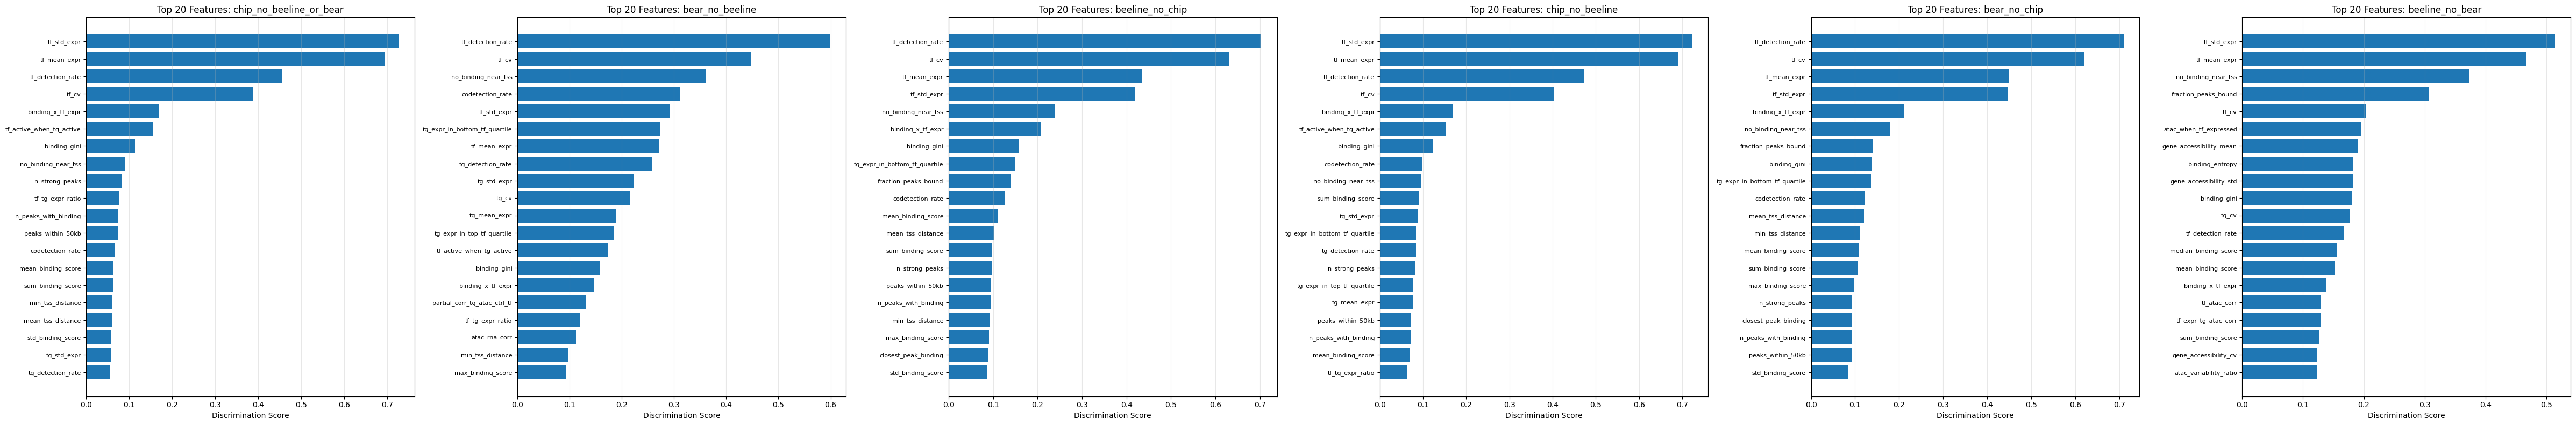

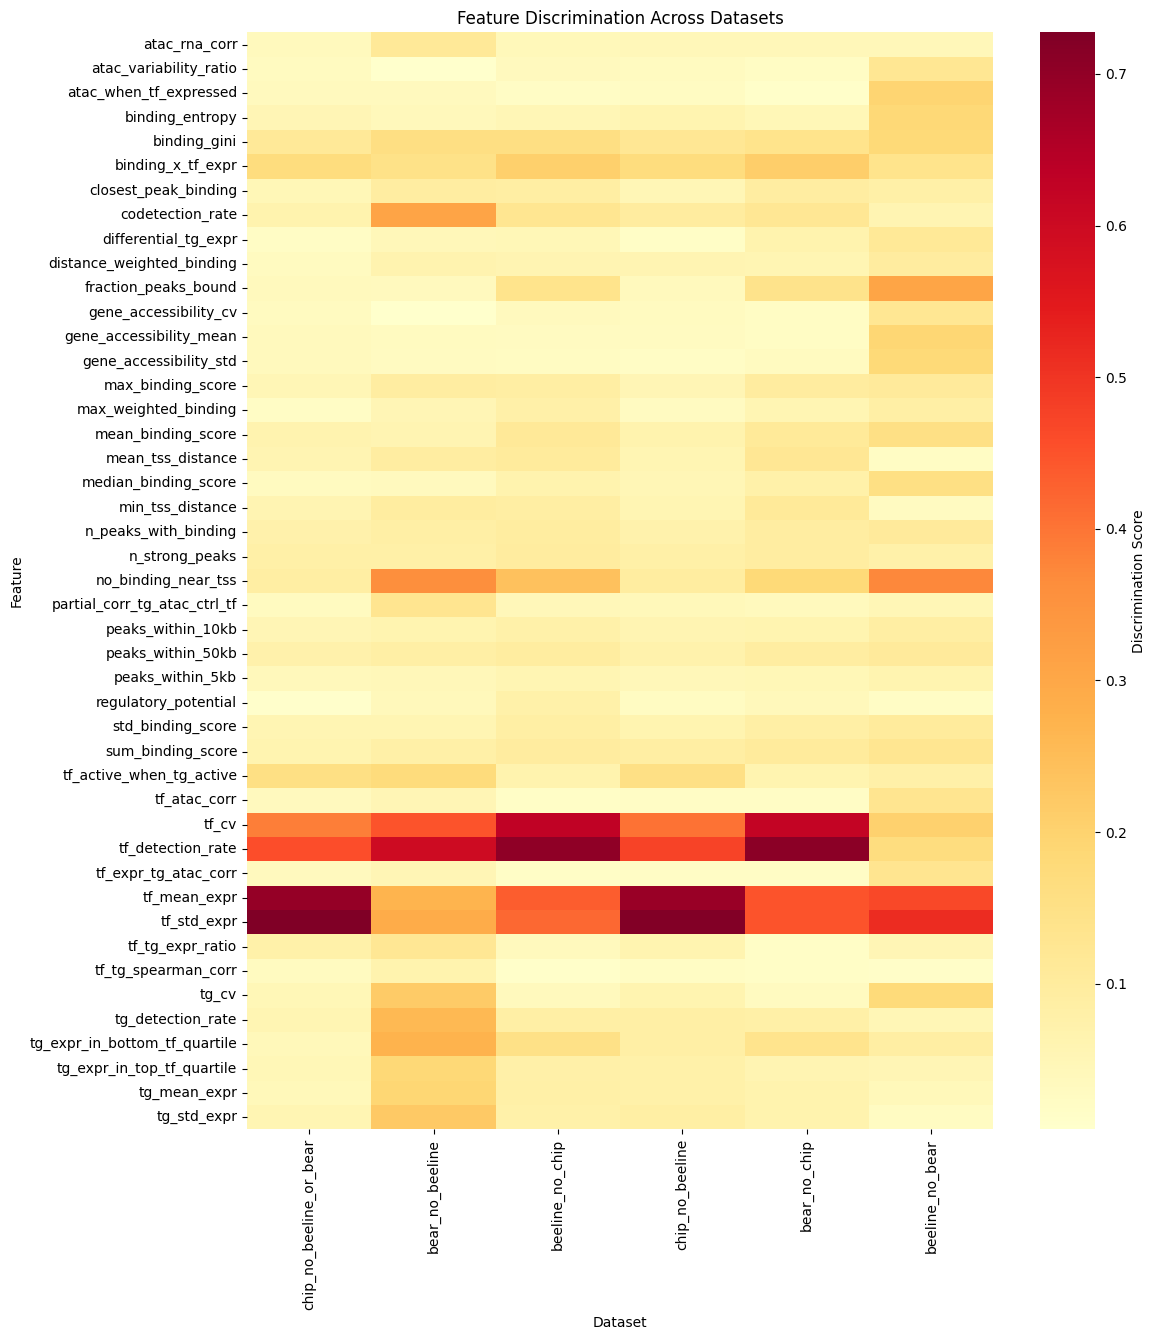


Saving results...
  Saved: feature_discrimination_chip_no_beeline_or_bear.csv
  Saved: feature_discrimination_bear_no_beeline.csv
  Saved: feature_discrimination_beeline_no_chip.csv
  Saved: feature_discrimination_chip_no_beeline.csv
  Saved: feature_discrimination_bear_no_chip.csv
  Saved: feature_discrimination_beeline_no_bear.csv

✓ Feature evaluation complete!


In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, mutual_info_score, matthews_corrcoef
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import mannwhitneyu, spearmanr
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# FEATURE EVALUATION FUNCTIONS
# ============================================================================

def label_edges(features_df, ground_truth_df, dataset_name):
    """
    Label edges as positive (1) if in ground truth, negative (0) otherwise.
    
    Parameters:
    -----------
    features_df : DataFrame with TF-TG pairs and features
    ground_truth_df : DataFrame with TF-TG pairs that are positive examples
    dataset_name : Name for the label column
    
    Returns:
    --------
    features_df with added label column
    """
    # Create set of positive edges for fast lookup
    positive_edges = set(zip(ground_truth_df['TF'], ground_truth_df['TG']))
    
    # Label edges
    labels = []
    for tf, tg in zip(features_df['TF'], features_df['TG']):
        labels.append(1 if (tf, tg) in positive_edges else 0)
    
    features_df[f'label_{dataset_name}'] = labels
    
    n_positive = sum(labels)
    n_total = len(labels)
    print(f"  {dataset_name}: {n_positive:,} positive / {n_total:,} total ({100*n_positive/n_total:.2f}%)")
    
    return features_df

from multiprocessing import Pool, cpu_count
from functools import partial
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, matthews_corrcoef
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import mannwhitneyu, spearmanr, rankdata
from tqdm.auto import tqdm

def compute_single_feature_metrics(feature_data):
    """
    Compute metrics for a single feature (for parallel processing).
    
    Parameters:
    -----------
    feature_data : tuple of (feature_name, feature_vals, labels)
    """
    feature_name, feature_vals, labels = feature_data
    
    # Skip if all NaN or constant
    if np.all(np.isnan(feature_vals)) or np.std(feature_vals) == 0:
        return None
    
    # Replace NaN with median
    feature_vals_clean = np.nan_to_num(feature_vals, nan=np.nanmedian(feature_vals))
    
    pos_vals = feature_vals_clean[labels == 1]
    neg_vals = feature_vals_clean[labels == 0]
    
    # 1. AUROC
    try:
        auroc = roc_auc_score(labels, feature_vals_clean)
        auroc_abs = max(auroc, 1 - auroc)
    except:
        auroc = 0.5
        auroc_abs = 0.5
    
    # 2. Mutual Information (expensive - make optional)
    try:
        mi = mutual_info_classif(
            feature_vals_clean.reshape(-1, 1), 
            labels, 
            discrete_features=False,
            random_state=42
        )[0]
    except:
        mi = 0.0
    
    # 3. Mann-Whitney U test
    try:
        u_stat, p_value = mannwhitneyu(pos_vals, neg_vals, alternative='two-sided')
        u_normalized = u_stat / (len(pos_vals) * len(neg_vals))
    except:
        p_value = 1.0
        u_normalized = 0.5
    
    # 4. Spearman correlation
    try:
        spearman_corr, spearman_p = spearmanr(feature_vals_clean, labels)
        if np.isnan(spearman_corr):
            spearman_corr = 0.0
    except:
        spearman_corr = 0.0
        spearman_p = 1.0
    
    # 5. Mean difference and Cohen's d
    mean_pos = np.mean(pos_vals)
    mean_neg = np.mean(neg_vals)
    std_all = np.std(feature_vals_clean)
    
    cohens_d = (mean_pos - mean_neg) / std_all if std_all > 0 else 0.0
    
    # 6. Matthews Correlation Coefficient (for binary features)
    if len(np.unique(feature_vals_clean)) <= 2:
        try:
            mcc = matthews_corrcoef(labels, feature_vals_clean)
        except:
            mcc = 0.0
    else:
        mcc = np.nan
    
    return {
        'feature': feature_name,
        'auroc': auroc,
        'auroc_abs': auroc_abs,
        'mutual_info': mi,
        'mann_whitney_u': u_normalized,
        'mann_whitney_p': p_value,
        'spearman_corr': spearman_corr,
        'spearman_p': spearman_p,
        'cohens_d': cohens_d,
        'mcc': mcc,
        'mean_positive': mean_pos,
        'mean_negative': mean_neg,
        'std_positive': np.std(pos_vals),
        'std_negative': np.std(neg_vals),
    }



def compute_feature_discrimination_fast(features_df, label_col, feature_cols, 
                                        use_parallel=True, n_jobs=-1, 
                                        compute_mi=True):
    """
    Fast computation of discrimination metrics using vectorization and parallel processing.
    
    Parameters:
    -----------
    features_df : DataFrame with features and labels
    label_col : Name of label column
    feature_cols : List of feature column names
    use_parallel : Whether to use parallel processing (default: True)
    n_jobs : Number of parallel jobs (-1 = all cores)
    compute_mi : Whether to compute mutual information (slow, default: True)
    
    Returns:
    --------
    DataFrame with discrimination metrics for each feature
    """
    print(f"\nComputing discrimination metrics for {label_col}...")
    
    labels = features_df[label_col].values
    n_positive = np.sum(labels)
    n_negative = len(labels) - n_positive
    
    if n_positive == 0 or n_negative == 0:
        print(f"  Warning: {label_col} has no positive or no negative examples!")
        return None
    
    print(f"  Positive: {n_positive:,} | Negative: {n_negative:,}")
    
    # ========================================================================
    # VECTORIZED STATISTICS (fast operations)
    # ========================================================================
    print("  Computing basic statistics (vectorized)...")
    
    # Extract all feature values at once
    feature_matrix = features_df[feature_cols].values  # (n_samples, n_features)
    
    # Replace NaN with column medians (vectorized)
    col_medians = np.nanmedian(feature_matrix, axis=0)
    nan_mask = np.isnan(feature_matrix)
    feature_matrix_clean = feature_matrix.copy()
    for i in range(feature_matrix.shape[1]):
        feature_matrix_clean[nan_mask[:, i], i] = col_medians[i]
    
    # Identify constant features (skip them)
    feature_stds = np.std(feature_matrix_clean, axis=0)
    valid_features = feature_stds > 0
    
    # Split by label
    pos_mask = labels == 1
    neg_mask = labels == 0
    
    # Vectorized means and stds
    mean_pos = np.mean(feature_matrix_clean[pos_mask], axis=0)
    mean_neg = np.mean(feature_matrix_clean[neg_mask], axis=0)
    std_pos = np.std(feature_matrix_clean[pos_mask], axis=0)
    std_neg = np.std(feature_matrix_clean[neg_mask], axis=0)
    
    # Cohen's d (vectorized)
    cohens_d = (mean_pos - mean_neg) / (feature_stds + 1e-10)
    
    # ========================================================================
    # AUROC (vectorized with batch processing)
    # ========================================================================
    print("  Computing AUROC (vectorized)...")
    
    auroc_scores = np.zeros(len(feature_cols))
    auroc_abs_scores = np.zeros(len(feature_cols))
    
    for i in range(len(feature_cols)):
        if not valid_features[i]:
            auroc_scores[i] = 0.5
            auroc_abs_scores[i] = 0.5
            continue
            
        try:
            auroc = roc_auc_score(labels, feature_matrix_clean[:, i])
            auroc_scores[i] = auroc
            auroc_abs_scores[i] = max(auroc, 1 - auroc)
        except:
            auroc_scores[i] = 0.5
            auroc_abs_scores[i] = 0.5
    
    # ========================================================================
    # EXPENSIVE METRICS (parallel processing)
    # ========================================================================
    
    if use_parallel and n_jobs != 1:
        print(f"  Computing expensive metrics (parallel, n_jobs={n_jobs if n_jobs > 0 else cpu_count()})...")
        
        # Prepare data for parallel processing
        feature_data_list = [
            (feature_cols[i], feature_matrix_clean[:, i], labels)
            for i in range(len(feature_cols))
            if valid_features[i]
        ]
        
        # Use multiprocessing
        n_workers = cpu_count() if n_jobs == -1 else min(n_jobs, cpu_count())
        
        with Pool(processes=n_workers) as pool:
            results_list = list(tqdm(
                pool.imap(compute_single_feature_metrics, feature_data_list),
                total=len(feature_data_list),
                desc="    Features"
            ))
        
        # Filter out None results
        results_list = [r for r in results_list if r is not None]
        
    else:
        print("  Computing expensive metrics (sequential)...")
        results_list = []
        
        for i in tqdm(range(len(feature_cols)), desc="    Features"):
            if not valid_features[i]:
                continue
                
            result = compute_single_feature_metrics(
                (feature_cols[i], feature_matrix_clean[:, i], labels)
            )
            
            if result is not None:
                results_list.append(result)
    
    # ========================================================================
    # COMBINE RESULTS
    # ========================================================================
    
    if len(results_list) == 0:
        print("  Warning: No valid features found!")
        return None
    
    results_df = pd.DataFrame(results_list)
    
    # Add composite score
    results_df['mi_norm'] = results_df['mutual_info'] / (results_df['mutual_info'].max() + 1e-10)
    results_df['auroc_score'] = (results_df['auroc_abs'] - 0.5) * 2
    results_df['cohens_d_abs'] = np.abs(results_df['cohens_d'])
    results_df['cohens_d_norm'] = results_df['cohens_d_abs'] / (results_df['cohens_d_abs'].max() + 1e-10)
    
    # Composite discrimination score
    results_df['discrimination_score'] = (
        results_df['auroc_score'] * 0.4 +
        results_df['mi_norm'] * 0.3 +
        results_df['cohens_d_norm'] * 0.3
    )
    
    # Sort by discrimination score
    results_df = results_df.sort_values('discrimination_score', ascending=False)
    
    return results_df


# ============================================================================
# ULTRA-FAST VERSION (Skip expensive metrics)
# ============================================================================

def compute_feature_discrimination_ultrafast(features_df, label_col, feature_cols):
    """
    Ultra-fast discrimination using only cheap metrics (AUROC and Cohen's d).
    Use this for quick initial screening.
    """
    print(f"\nComputing discrimination metrics (ultra-fast) for {label_col}...")
    
    labels = features_df[label_col].values
    n_positive = np.sum(labels)
    n_negative = len(labels) - n_positive
    
    if n_positive == 0 or n_negative == 0:
        print(f"  Warning: {label_col} has no positive or no negative examples!")
        return None
    
    # Extract all feature values
    feature_matrix = features_df[feature_cols].values
    
    # Replace NaN with column medians
    col_medians = np.nanmedian(feature_matrix, axis=0)
    nan_mask = np.isnan(feature_matrix)
    feature_matrix_clean = feature_matrix.copy()
    for i in range(feature_matrix.shape[1]):
        feature_matrix_clean[nan_mask[:, i], i] = col_medians[i]
    
    # Identify constant features
    feature_stds = np.std(feature_matrix_clean, axis=0)
    valid_features = feature_stds > 0
    
    # Split by label
    pos_mask = labels == 1
    neg_mask = labels == 0
    
    # Vectorized statistics
    mean_pos = np.mean(feature_matrix_clean[pos_mask], axis=0)
    mean_neg = np.mean(feature_matrix_clean[neg_mask], axis=0)
    std_pos = np.std(feature_matrix_clean[pos_mask], axis=0)
    std_neg = np.std(feature_matrix_clean[neg_mask], axis=0)
    cohens_d = (mean_pos - mean_neg) / (feature_stds + 1e-10)
    
    # Vectorized AUROC
    auroc_scores = []
    for i in tqdm(range(len(feature_cols)), desc="  Computing AUROC"):
        if not valid_features[i]:
            auroc_scores.append(0.5)
            continue
        try:
            auroc = roc_auc_score(labels, feature_matrix_clean[:, i])
            auroc_scores.append(max(auroc, 1 - auroc))
        except:
            auroc_scores.append(0.5)
    
    # Create results dataframe
    results_df = pd.DataFrame({
        'feature': feature_cols,
        'auroc_abs': auroc_scores,
        'cohens_d': cohens_d,
        'cohens_d_abs': np.abs(cohens_d),
        'mean_positive': mean_pos,
        'mean_negative': mean_neg,
        'std_positive': std_pos,
        'std_negative': std_neg,
    })
    
    # Filter valid features
    results_df = results_df[valid_features].copy()
    
    # Normalized scores
    results_df['auroc_score'] = (results_df['auroc_abs'] - 0.5) * 2
    results_df['cohens_d_norm'] = results_df['cohens_d_abs'] / (results_df['cohens_d_abs'].max() + 1e-10)
    
    # Simple discrimination score (no MI)
    results_df['discrimination_score'] = (
        results_df['auroc_score'] * 0.6 +
        results_df['cohens_d_norm'] * 0.4
    )
    
    results_df = results_df.sort_values('discrimination_score', ascending=False)
    
    return results_df

def stratified_subsample(features_df, label_col, sample_size=50000, random_state=42):
    """
    Create a stratified subsample maintaining class balance.
    
    Parameters:
    -----------
    features_df : DataFrame with features and labels
    label_col : Name of label column
    sample_size : Total sample size (will be split proportionally by class)
    random_state : Random seed for reproducibility
    
    Returns:
    --------
    Subsampled DataFrame
    """
    np.random.seed(random_state)
    
    # Get positive and negative indices
    pos_idx = features_df[features_df[label_col] == 1].index
    neg_idx = features_df[features_df[label_col] == 0].index
    
    n_pos = len(pos_idx)
    n_neg = len(neg_idx)
    total = n_pos + n_neg
    
    # Calculate stratified sample sizes
    pos_ratio = n_pos / total
    n_pos_sample = min(int(sample_size * pos_ratio), n_pos)
    n_neg_sample = min(sample_size - n_pos_sample, n_neg)
    
    # Random sample from each class
    pos_sample_idx = np.random.choice(pos_idx, size=n_pos_sample, replace=False)
    neg_sample_idx = np.random.choice(neg_idx, size=n_neg_sample, replace=False)
    
    # Combine and shuffle
    sample_idx = np.concatenate([pos_sample_idx, neg_sample_idx])
    np.random.shuffle(sample_idx)
    
    sampled_df = features_df.loc[sample_idx].copy()
    
    print(f"  Subsampled: {len(sampled_df):,} rows (pos: {n_pos_sample:,}, neg: {n_neg_sample:,})")
    print(f"  Original:   {total:,} rows (pos: {n_pos:,}, neg: {n_neg:,})")
    print(f"  Ratio preserved: {n_pos_sample/len(sampled_df):.3f} vs {pos_ratio:.3f}")
    
    return sampled_df

def evaluate_features_across_datasets(features_df, ground_truth_dfs, negative_sample_ratio=1.0):
    # Get feature columns (exclude TF, TG, and any existing labels)
    exclude_cols = ['TF', 'TG'] + [col for col in features_df.columns if col.startswith('label_')]
    feature_cols = [col for col in features_df.columns if col not in exclude_cols]
    
    print(f"Evaluating {len(feature_cols)} features across {len(ground_truth_dfs)} datasets...")
    print(f"Total TF-TG pairs in features_df: {len(features_df):,}\n")
    
    # --- Label edges ONCE for all datasets ---
    print("Labeling edges...")
    features_df_labeled = features_df.copy()
    for dataset_name, gt_df in ground_truth_dfs.items():
        features_df_labeled = label_edges(features_df_labeled, gt_df, dataset_name)
    
    # Optionally balance classes by sampling negatives (stub)
    if negative_sample_ratio < 1.0:
        print(f"\nBalancing classes (negative_sample_ratio={negative_sample_ratio})...")
        # implement if you want negative subsampling
    
    discrimination_results = {}
    for dataset_name in ground_truth_dfs.keys():
        label_col = f'label_{dataset_name}'
        
        # Stratified sample for this specific dataset
        sampled_df = stratified_subsample(
            features_df_labeled,
            label_col,
            sample_size=100_000,
            random_state=42,
        )
        
        results_df = compute_feature_discrimination_fast(
            sampled_df,
            label_col,
            feature_cols,
            use_parallel=True,
            n_jobs=12,
        )
        discrimination_results[dataset_name] = results_df

    # If you really want an ultrafast run, you probably want to loop per dataset too:
    # (or drop this block if you don't need it)
    # results_df_fast = compute_feature_discrimination_ultrafast(
    #     features_df_labeled,
    #     label_col,  # but which dataset? consider turning this into a per-dataset loop
    #     feature_cols,
    # )
    
    return discrimination_results, features_df_labeled

# ============================================================================
# VISUALIZATION FUNCTIONS
# ============================================================================

def plot_top_features(discrimination_results, top_n=20, metric='discrimination_score'):
    """
    Plot top N features for each dataset.
    """
    n_datasets = len(discrimination_results)
    fig, axes = plt.subplots(1, n_datasets, figsize=(8*n_datasets, 8))
    
    if n_datasets == 1:
        axes = [axes]
    
    for idx, (dataset_name, results_df) in enumerate(discrimination_results.items()):
        if results_df is None:
            continue
            
        top_features = results_df.nsmallest(top_n, metric) if metric == 'mann_whitney_p' else results_df.nlargest(top_n, metric)
        
        ax = axes[idx]
        ax.barh(range(len(top_features)), top_features[metric].values)
        ax.set_yticks(range(len(top_features)))
        ax.set_yticklabels(top_features['feature'].values, fontsize=8)
        ax.set_xlabel(metric.replace('_', ' ').title())
        ax.set_title(f'Top {top_n} Features: {dataset_name}')
        ax.invert_yaxis()
        ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_feature_comparison_heatmap(discrimination_results, top_n=30):
    """
    Create heatmap comparing feature importance across datasets.
    """
    # Get top N features from each dataset
    all_top_features = set()
    for results_df in discrimination_results.values():
        if results_df is not None:
            all_top_features.update(results_df.head(top_n)['feature'].values)
    
    # Create matrix of discrimination scores
    feature_list = sorted(all_top_features)
    dataset_names = list(discrimination_results.keys())
    
    matrix = np.zeros((len(feature_list), len(dataset_names)))
    
    for j, dataset_name in enumerate(dataset_names):
        results_df = discrimination_results[dataset_name]
        if results_df is not None:
            for i, feature in enumerate(feature_list):
                row = results_df[results_df['feature'] == feature]
                if len(row) > 0:
                    matrix[i, j] = row['discrimination_score'].values[0]
    
    # Plot heatmap
    plt.figure(figsize=(max(8, len(dataset_names) * 2), max(10, len(feature_list) * 0.3)))
    sns.heatmap(
        matrix, 
        xticklabels=dataset_names,
        yticklabels=feature_list,
        cmap='YlOrRd',
        annot=False,
        cbar_kws={'label': 'Discrimination Score'}
    )
    plt.title('Feature Discrimination Across Datasets')
    plt.xlabel('Dataset')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

def create_feature_summary_table(discrimination_results):
    """
    Create summary table showing top features for each dataset.
    """
    summary_data = []
    
    for dataset_name, results_df in discrimination_results.items():
        if results_df is not None:
            top_10 = results_df.head(10)
            for idx, row in top_10.iterrows():
                summary_data.append({
                    'Dataset': dataset_name,
                    'Rank': idx + 1,
                    'Feature': row['feature'],
                    'AUROC': f"{row['auroc']:.3f}",
                    'Mutual Info': f"{row['mutual_info']:.4f}",
                    "Cohen's d": f"{row['cohens_d']:.3f}",
                    'Discrimination Score': f"{row['discrimination_score']:.3f}",
                })
    
    summary_df = pd.DataFrame(summary_data)
    return summary_df

# ============================================================================
# MAIN EVALUATION PIPELINE
# ============================================================================

# Define ground truth datasets
ground_truth_dfs = {
    'chip_no_beeline_or_bear': dfs['chip_no_beeline_or_bear_df'],
    'bear_no_beeline': dfs['bear_no_beeline_df'],
    'beeline_no_chip': dfs['beeline_no_chip_df'],
    'chip_no_beeline': dfs['chip_no_beeline_df'],  # Add more as needed
    'bear_no_chip': dfs['bear_no_chip_df'],
    'beeline_no_bear': dfs['beeline_no_bear_df'],
}

# Run evaluation
discrimination_results, features_df_labeled = evaluate_features_across_datasets(
    features_df=features_df,
    ground_truth_dfs=ground_truth_dfs
)

# Display top 20 features for each dataset
print("\n" + "="*80)
print("TOP 20 FEATURES BY DISCRIMINATION SCORE")
print("="*80)

for dataset_name, results_df in discrimination_results.items():
    if results_df is not None:
        print(f"\n{dataset_name.upper()}")
        print("-" * 80)
        display_cols = ['feature', 'auroc', 'mutual_info', 'cohens_d', 'discrimination_score']
        print(results_df[display_cols].head(20).to_string(index=False))

# Create summary table
summary_table = create_feature_summary_table(discrimination_results)
print("\n" + "="*80)
print("FEATURE SUMMARY TABLE (Top 10 per dataset)")
print("="*80)
print(summary_table.to_string(index=False))

# Visualizations
print("\nGenerating visualizations...")
plot_top_features(discrimination_results, top_n=20, metric='discrimination_score')
plot_feature_comparison_heatmap(discrimination_results, top_n=30)

# Save results
print("\nSaving results...")
for dataset_name, results_df in discrimination_results.items():
    if results_df is not None:
        results_df.to_csv(base / f'feature_discrimination_{dataset_name}.csv')
        print(f"  Saved: feature_discrimination_{dataset_name}.csv")

print("\n✓ Feature evaluation complete!")

In [4]:
features_df_labeled.columns

Index(['TF', 'TG', 'max_binding_score', 'mean_binding_score',
       'median_binding_score', 'std_binding_score', 'sum_binding_score',
       'distance_weighted_binding', 'max_weighted_binding',
       'n_peaks_with_binding', 'proximity_binding_score', 'peaks_within_1kb',
       'peaks_within_5kb', 'peaks_within_10kb', 'peaks_within_50kb',
       'fraction_peaks_bound', 'n_strong_peaks', 'min_tss_distance',
       'mean_tss_distance', 'closest_peak_binding', 'binding_entropy',
       'binding_gini', 'no_binding_near_tss', 'tf_mean_expr', 'tf_std_expr',
       'tf_cv', 'tf_detection_rate', 'tg_mean_expr', 'tg_std_expr', 'tg_cv',
       'tg_detection_rate', 'tf_tg_expr_ratio', 'tf_tg_pearson_corr',
       'tf_tg_spearman_corr', 'codetection_rate', 'tf_active_when_tg_active',
       'tg_expr_in_top_tf_quartile', 'tg_expr_in_bottom_tf_quartile',
       'differential_tg_expr', 'tf_not_expressed', 'anticorrelation_flag',
       'gene_accessibility_mean', 'gene_accessibility_std',
       'gen

count    3.289937e+06
mean     1.351858e+00
std      7.082242e+00
min     -0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      9.555551e-01
max      3.230052e+02
Name: max_binding_score, dtype: float64
% zeros: 0.564231169168285


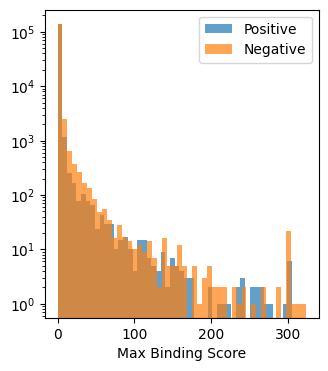

In [7]:
# Check if binding scores actually vary
print(features_df['max_binding_score'].describe())
print(f"% zeros: {(features_df['max_binding_score'] == 0).mean()}")

# Plot distribution for positive vs negative edges
pos_scores = features_df_labeled[features_df_labeled['label_chip_no_beeline'] == 1]['max_binding_score']
neg_scores = features_df_labeled[features_df_labeled['label_chip_no_beeline'] == 0]['max_binding_score']

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.hist(pos_scores, bins=50, alpha=0.7, label='Positive', log=True)
plt.hist(neg_scores.sample(len(pos_scores)), bins=50, alpha=0.7, label='Negative', log=True)
plt.xlabel('Max Binding Score')
plt.legend()

In [8]:
print(features_df[['tf_tg_pearson_corr', 'tf_tg_spearman_corr']].describe())


       tf_tg_pearson_corr  tf_tg_spearman_corr
count        3.289937e+06         3.289937e+06
mean         3.573825e-03         5.472449e-03
std          7.786436e-02         7.736306e-02
min         -8.581918e-01        -7.865277e-01
25%          0.000000e+00         0.000000e+00
50%          0.000000e+00         0.000000e+00
75%          0.000000e+00         0.000000e+00
max          1.000000e+00         1.000000e+00


In [9]:
# Check the sliding_window_df
print("Unique TFs in sliding_window_df:", sliding_window_df['TF'].nunique())
print("Unique peaks:", sliding_window_df['peak_id'].nunique())
print("Score distribution:", sliding_window_df['sliding_window_score'].describe())

# Are there ANY TFs with good scores?
high_score_tfs = sliding_window_df[sliding_window_df['sliding_window_score'] > 5]['TF'].unique()
print(f"TFs with high scores: {len(high_score_tfs)}")

Unique TFs in sliding_window_df: 217
Unique peaks: 57320
Score distribution: count    1.081055e+08
mean     2.851570e-01
std      4.008525e+00
min     -0.000000e+00
25%     -0.000000e+00
50%     -0.000000e+00
75%      0.000000e+00
max      3.233062e+02
Name: sliding_window_score, dtype: float64
TFs with high scores: 205


BINDING SCORES FOR CHIP-VALIDATED EDGES

ChIP-validated edges (n=139,936):
count    139936.000000
mean          1.111812
std           5.756042
min          -0.000000
25%          -0.000000
50%          -0.000000
75%           0.955555
max         304.640198
Name: max_binding_score, dtype: float64
% with any motif (score > 0): 48.8%
% with p < 0.01 (score > 2): 15.7%
% with p < 0.00001 (score > 5): 2.7%

Random edges (n=139,936):
count    139936.000000
mean          1.359599
std           7.143413
min          -0.000000
25%          -0.000000
50%          -0.000000
75%           0.955555
max         317.258392
Name: max_binding_score, dtype: float64
% with any motif (score > 0): 43.3%
% with p < 0.01 (score > 2): 17.3%
% with p < 0.00001 (score > 5): 4.6%

Mann-Whitney U test (ChIP > random): p = 1.64e-78


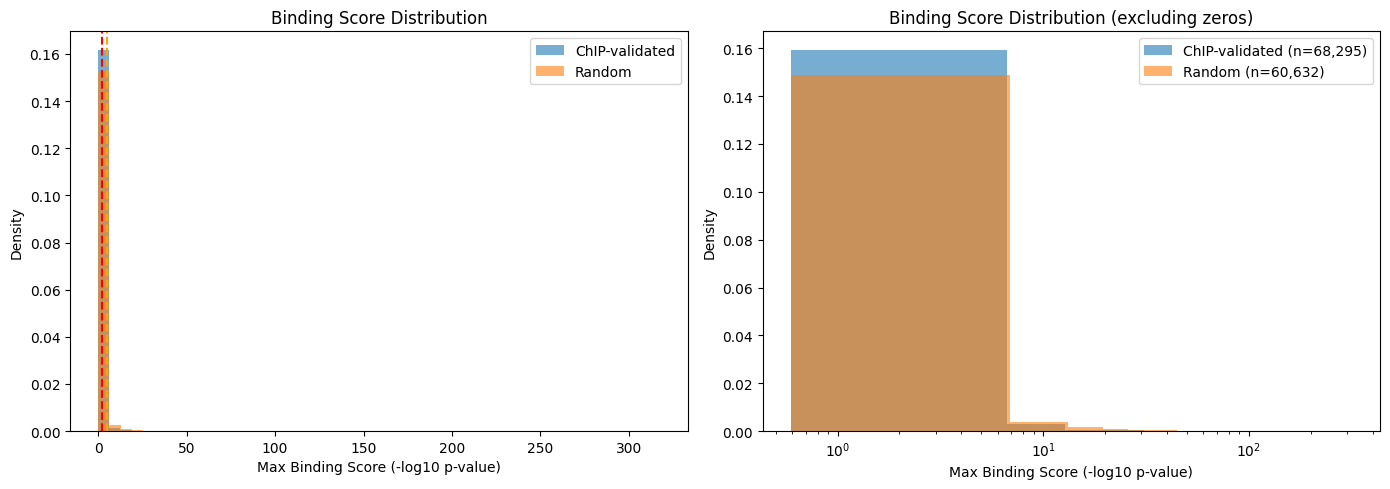

In [10]:
# Critical diagnostic
print("="*80)
print("BINDING SCORES FOR CHIP-VALIDATED EDGES")
print("="*80)

# Get ChIP-validated edges
chip_edges = features_df_labeled[features_df_labeled['label_chip_no_beeline_or_bear'] == 1]
random_edges = features_df_labeled[features_df_labeled['label_chip_no_beeline_or_bear'] == 0].sample(n=len(chip_edges))

print(f"\nChIP-validated edges (n={len(chip_edges):,}):")
print(chip_edges['max_binding_score'].describe())
print(f"% with any motif (score > 0): {(chip_edges['max_binding_score'] > 0).mean()*100:.1f}%")
print(f"% with p < 0.01 (score > 2): {(chip_edges['max_binding_score'] > 2).mean()*100:.1f}%")
print(f"% with p < 0.00001 (score > 5): {(chip_edges['max_binding_score'] > 5).mean()*100:.1f}%")

print(f"\nRandom edges (n={len(random_edges):,}):")
print(random_edges['max_binding_score'].describe())
print(f"% with any motif (score > 0): {(random_edges['max_binding_score'] > 0).mean()*100:.1f}%")
print(f"% with p < 0.01 (score > 2): {(random_edges['max_binding_score'] > 2).mean()*100:.1f}%")
print(f"% with p < 0.00001 (score > 5): {(random_edges['max_binding_score'] > 5).mean()*100:.1f}%")

# Statistical test
from scipy.stats import mannwhitneyu
u_stat, p_val = mannwhitneyu(chip_edges['max_binding_score'], 
                              random_edges['max_binding_score'], 
                              alternative='greater')
print(f"\nMann-Whitney U test (ChIP > random): p = {p_val:.2e}")

# Plot with log scale
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
ax1.hist(chip_edges['max_binding_score'], bins=50, alpha=0.6, label='ChIP-validated', density=True)
ax1.hist(random_edges['max_binding_score'], bins=50, alpha=0.6, label='Random', density=True)
ax1.set_xlabel('Max Binding Score (-log10 p-value)')
ax1.set_ylabel('Density')
ax1.set_title('Binding Score Distribution')
ax1.legend()
ax1.axvline(x=2, color='r', linestyle='--', label='p=0.01')
ax1.axvline(x=5, color='orange', linestyle='--', label='p=0.00001')

# Log scale (excluding zeros)
chip_nonzero = chip_edges[chip_edges['max_binding_score'] > 0]['max_binding_score']
random_nonzero = random_edges[random_edges['max_binding_score'] > 0]['max_binding_score']

ax2.hist(chip_nonzero, bins=50, alpha=0.6, label=f'ChIP-validated (n={len(chip_nonzero):,})', density=True)
ax2.hist(random_nonzero, bins=50, alpha=0.6, label=f'Random (n={len(random_nonzero):,})', density=True)
ax2.set_xlabel('Max Binding Score (-log10 p-value)')
ax2.set_ylabel('Density')
ax2.set_title('Binding Score Distribution (excluding zeros)')
ax2.set_xscale('log')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:

# Check what columns peak_to_gene_dist_df has
print("Columns in peak_to_gene_dist_df:", peak_to_gene_dist_df.columns.tolist())

# Get distance distribution for ChIP edges
chip_edge_distances = []
for _, edge in chip_edges.iterrows():
    tf = edge['TF']
    tg = edge['TG']
    
    # Get all peaks linked to this gene
    gene_peaks = peak_to_gene_dist_df[peak_to_gene_dist_df['TG'] == tg]
    
    # Get binding scores for this TF on these peaks
    tf_peak_binding = sliding_window_df[
        (sliding_window_df['TF'] == tf) & 
        (sliding_window_df['peak_id'].isin(gene_peaks['peak_id']))
    ]
    
    if len(tf_peak_binding) > 0:
        # Get the peak with max binding
        max_binding_peak = tf_peak_binding.loc[tf_peak_binding['sliding_window_score'].idxmax()]
        peak_id = max_binding_peak['peak_id']
        
        # Get distance for this peak
        peak_dist = gene_peaks[gene_peaks['peak_id'] == peak_id]['tss_distance'].values
        if len(peak_dist) > 0:
            chip_edge_distances.append(abs(peak_dist[0]))

chip_edge_distances = np.array(chip_edge_distances)

print(f"\nDistance from TSS for peaks with max binding score:")
print(f"  n = {len(chip_edge_distances):,}")
print(f"  Mean: {chip_edge_distances.mean():,.0f} bp")
print(f"  Median: {np.median(chip_edge_distances):,.0f} bp")
print(f"  % within 1kb: {(chip_edge_distances < 1000).mean()*100:.1f}%")
print(f"  % within 10kb: {(chip_edge_distances < 10000).mean()*100:.1f}%")
print(f"  % within 50kb: {(chip_edge_distances < 50000).mean()*100:.1f}%")
print(f"  % within 100kb: {(chip_edge_distances < 100000).mean()*100:.1f}%")

# Compare to all peak-gene links
all_distances = peak_to_gene_dist_df['tss_distance'].abs()
print(f"\nAll peak-to-gene links (n={len(all_distances):,}):")
print(f"  Mean: {all_distances.mean():,.0f} bp")
print(f"  Median: {all_distances.median():,.0f} bp")
print(f"  % within 10kb: {(all_distances < 10000).mean()*100:.1f}%")

In [12]:
# Create strict peak-to-gene links
peak_to_gene_strict = peak_to_gene_dist_df[
    peak_to_gene_dist_df['tss_distance'].abs() < 2000  # ±2kb from TSS
].copy()

print(f"Original peak-gene links: {len(peak_to_gene_dist_df):,}")
print(f"Strict promoter links: {len(peak_to_gene_strict):,}")

# Recompute features with strict links
features_df_strict = compute_all_features(
    sliding_window_df=sliding_window_df,
    peak_to_gene_dist_df=peak_to_gene_strict,  # Use strict links
    rna_df=rna_pseudobulk_df,
    atac_df=atac_pseudobulk_df
)


Original peak-gene links: 31,182
Strict promoter links: 3,318
Pre-computing correlation matrices...

[1/4] Computing gene accessibility...


  Gene accessibility:   0%|          | 0/3102 [00:00<?, ?it/s]


[2/4] Computing TF-TG expression correlations...
  Computing Pearson correlations (vectorized)...


  Storing Pearson:   0%|          | 0/2925 [00:00<?, ?it/s]

  Computing Spearman correlations (vectorized)...


  Storing Spearman:   0%|          | 0/2925 [00:00<?, ?it/s]


[3/4] Computing TF-accessibility correlations...


  TF-accessibility:   0%|          | 0/2925 [00:00<?, ?it/s]


[4/4] Computing TG expression-accessibility correlations...


  Gene expr-accessibility:   0%|          | 0/3102 [00:00<?, ?it/s]


✓ Correlation matrices computed!

Merging sliding window with peak-to-gene distances...
  Merged shape: (6257748, 6)
Computing binding features...
Computing binding features (vectorized)...
  Phase 1: Basic aggregations...
  Phase 2: Strong peaks (75th percentile)...
  Phase 3: Distance features (numba-accelerated)...


    Distance features:   0%|          | 0/673134 [00:00<?, ?it/s]

  Phase 4: Entropy and Gini (numba-accelerated)...


    Entropy/Gini:   0%|          | 0/673134 [00:00<?, ?it/s]

✓ Computed binding features for 673134 TF-TG pairs

  Computed binding features for 673134 TF-TG pairs

Adding expression features...
  Pre-computing gene statistics...


    Gene stats:   0%|          | 0/2925 [00:00<?, ?it/s]

  Extracting features...


  Processing batches:   0%|          | 0/68 [00:00<?, ?it/s]

  ✓ Expression features added

Adding accessibility features...
  Pre-computing TF expression data...


    TF data:   0%|          | 0/217 [00:00<?, ?it/s]

  Processing accessibility features...


    Batches:   0%|          | 0/68 [00:00<?, ?it/s]

  ✓ Accessibility features added

Adding interaction features...
  ✓ Interaction features added

Cleaning up features...

✓ Feature computation complete!
  Final shape: (673134, 54)
  Features: 52 (excluding TF and TG columns)


In [35]:
known_pairs = [
    ('SOX2', 'NANOG'),
    ('OCT4', 'SOX2'),
    # Add more based on your cell type
]

rna_df = dfs['rna_pseudobulk_df']
for tf, tg in known_pairs:
    if tf in features_df.index and tg in rna_df.index:
        pair_data = features_df[(features_df['TF']==tf) & (features_df['TG']==tg)]
        if len(pair_data) > 0:
            print(f"{tf} → {tg}: binding_score = {pair_data['max_binding_score'].values[0]:.2f}")

In [ ]:
chip_no_beeline_or_bear_df = dfs['chip_no_beeline_or_bear_df']
chip_no_beeline_df = dfs['chip_no_beeline_df']
chip_no_bear_df = dfs['chip_no_bear_df']

# Option 1: Hold out entire TFs (most stringent)
train_tfs = chip_no_beeline_or_bear_df['TF'].unique()[:40]  # 80% of TFs
test_tfs = chip_no_beeline_or_bear_df['TF'].unique()[40:]   # 20% of TFs

train_edges = chip_no_beeline_or_bear_df[chip_no_beeline_or_bear_df['TF'].isin(train_tfs)]
test_edges = chip_no_beeline_or_bear_df[chip_no_beeline_or_bear_df['TF'].isin(test_tfs)]

# Option 2: Hold out TF-gene pairs (easier, tests generalization to new genes)
from sklearn.model_selection import train_test_split
train_edges, test_edges = train_test_split(
    chip_no_beeline_or_bear_df, 
    test_size=0.2, 
    stratify=chip_no_beeline_or_bear_df['TF']  # Keep TF distribution similar
)

chip_orti = pd.read_csv("data/ground_truth_files/ORTI_ground_truth_TF_TG.csv").rename(columns={"Gene1": "TF", "Gene2": "TG"})

# Option 3: Cross-dataset (train on chip_no_beeline, test on chip_no_bear)
train_edges = chip_no_beeline_df
test_edges = chip_no_bear_df  # Must have no overlap!

CREATING TRAINING AND TEST DATASETS

Ground truth sizes:
  chip_no_beeline_or_bear: 393,555 edges
  chip_no_beeline: 395,981 edges
  chip_no_bear: 393,662 edges
  bear_no_chip: 953,532 edges
  beeline_no_chip: 918,026 edges
  bear_no_beeline: 60,150 edges
  beeline_no_bear: 22,325 edges
  orti: 3,950 edges

Overlap between ChIP and ORTI: 266 edges (8.8% of ORTI)

--------------------------------------------------------------------------------
TRAINING SET (ChIP-seq edges)
--------------------------------------------------------------------------------
  Total TF-TG pairs in features: 3,289,937
  Positive edges to include: 393,555
  Total positive edges (all ground truths): 1,374,439


  Finding negatives:   0%|          | 0/3289937 [00:00<?, ?it/s]

  Negative candidates: 3,139,763
  Final dataset: 470,446 samples
    Positive: 76,891 (16.3%)
    Negative: 393,555 (83.7%)

--------------------------------------------------------------------------------
TEST SET (ORTI edges)
--------------------------------------------------------------------------------
  Total TF-TG pairs in features: 3,289,937
  Positive edges to include: 3,026
  Total positive edges (all ground truths): 1,374,439


  Finding negatives:   0%|          | 0/3289937 [00:00<?, ?it/s]

  Negative candidates: 3,139,763
  Final dataset: 3,628 samples
    Positive: 602 (16.6%)
    Negative: 3,026 (83.4%)

PREPARING FEATURES
Number of features: 52

Training set: (470446, 52)
Test set: (3628, 52)

TRAINING MODELS

--------------------------------------------------------------------------------
Training Logistic Regression...
--------------------------------------------------------------------------------
  Train AUROC: 0.7087
  Test AUROC:  0.5895
  Train AUPRC: 0.3727
  Test AUPRC:  0.2011

--------------------------------------------------------------------------------
Training Random Forest...
--------------------------------------------------------------------------------
  Train AUROC: 0.9662
  Test AUROC:  0.5955
  Train AUPRC: 0.8217
  Test AUPRC:  0.2596

--------------------------------------------------------------------------------
Training Gradient Boosting...
--------------------------------------------------------------------------------
  Train AUROC: 0.979

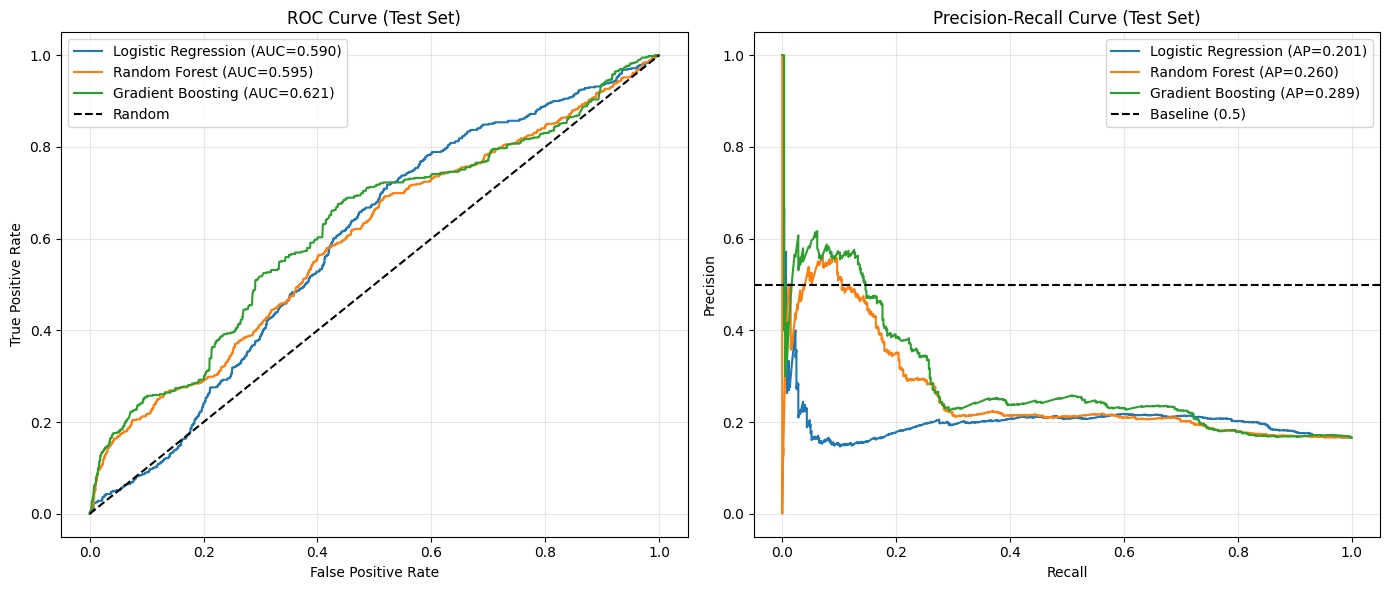

  Saved: feature_importance.png


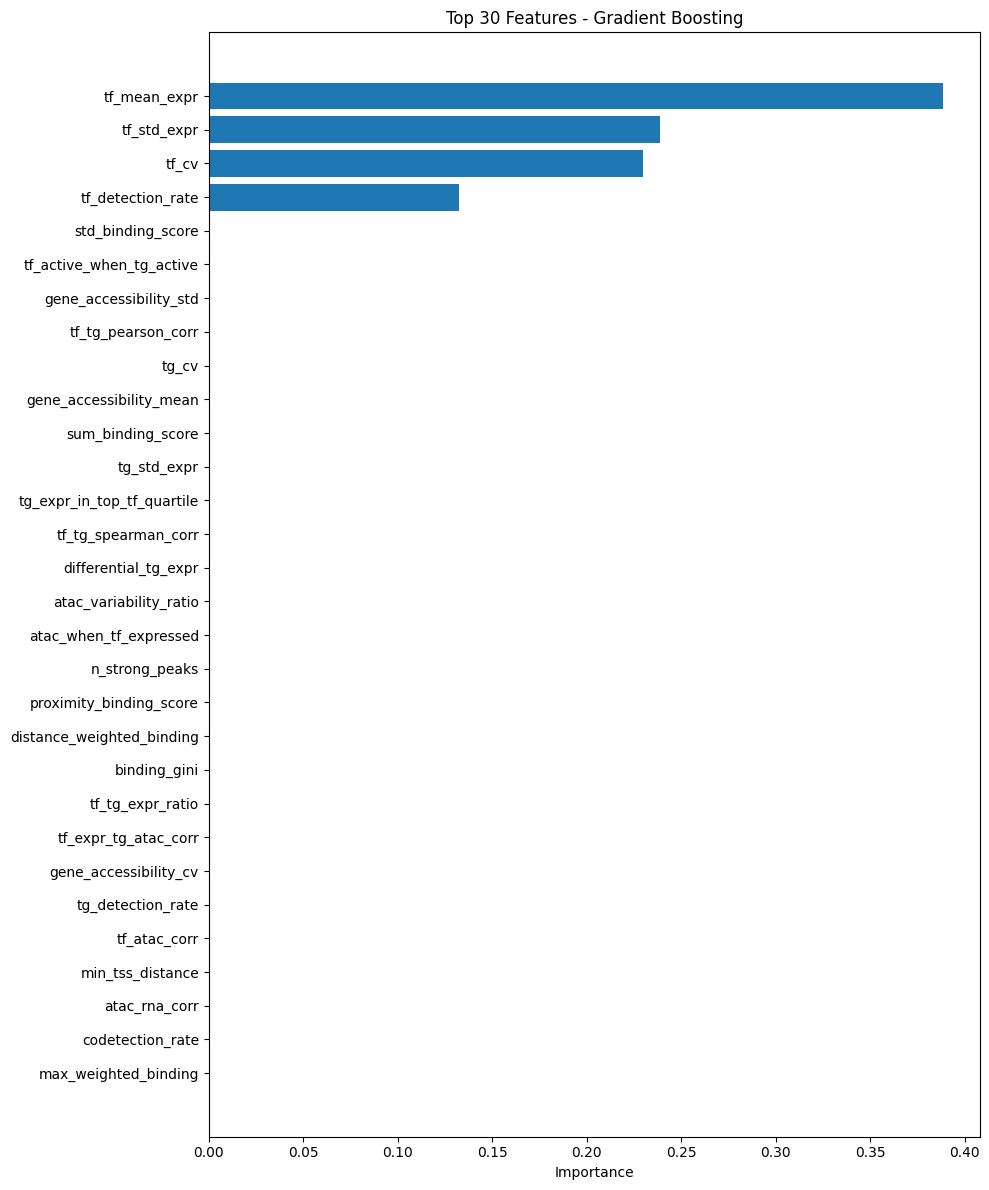


✓ Training and evaluation complete!


In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# ============================================================================
# 1. LOAD DATA AND CREATE TRAIN/TEST SPLITS
# ============================================================================

def create_balanced_dataset(positive_edges, all_features_df, ground_truth_dfs_dict, 
                           balance_ratio=1.0, random_state=42):
    """
    Create balanced dataset with positive edges and negative samples.
    
    Parameters:
    -----------
    positive_edges : DataFrame with TF-TG pairs that are positive examples
    all_features_df : DataFrame with features for ALL possible TF-TG pairs
    ground_truth_dfs_dict : Dict of all ground truth datasets (to exclude from negatives)
    balance_ratio : Ratio of negatives to positives (1.0 = balanced)
    random_state : Random seed
    
    Returns:
    --------
    balanced_df : DataFrame with balanced positive and negative samples
    """
    np.random.seed(random_state)
    
    # Create set of ALL positive edges (from all ground truths)
    all_positive_edges = set()
    for gt_name, gt_df in ground_truth_dfs_dict.items():
        for _, row in gt_df.iterrows():
            all_positive_edges.add((row['TF'], row['TG']))
    
    # Create set of current positive edges
    current_positive_edges = set()
    for _, row in positive_edges.iterrows():
        current_positive_edges.add((row['TF'], row['TG']))
    
    # Find all edges in features_df that are NOT in any ground truth
    print(f"  Total TF-TG pairs in features: {len(all_features_df):,}")
    print(f"  Positive edges to include: {len(current_positive_edges):,}")
    print(f"  Total positive edges (all ground truths): {len(all_positive_edges):,}")
    
    # Create candidate negative pool (not in ANY ground truth)
    negative_candidates = []
    for idx, row in tqdm(all_features_df.iterrows(), total=len(all_features_df), desc="  Finding negatives"):
        edge = (row['TF'], row['TG'])
        if edge not in all_positive_edges:
            negative_candidates.append(idx)
    
    print(f"  Negative candidates: {len(negative_candidates):,}")
    
    # Sample negatives
    n_negatives = int(len(current_positive_edges) * balance_ratio)
    n_negatives = min(n_negatives, len(negative_candidates))
    
    sampled_negative_indices = np.random.choice(negative_candidates, size=n_negatives, replace=False)
    
    # Create positive dataframe
    positive_df = all_features_df[
        all_features_df.apply(lambda x: (x['TF'], x['TG']) in current_positive_edges, axis=1)
    ].copy()
    positive_df['label'] = 1
    
    # Create negative dataframe
    negative_df = all_features_df.loc[sampled_negative_indices].copy()
    negative_df['label'] = 0
    
    # Combine and shuffle
    balanced_df = pd.concat([positive_df, negative_df], ignore_index=True)
    balanced_df = balanced_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    print(f"  Final dataset: {len(balanced_df):,} samples")
    print(f"    Positive: {(balanced_df['label'] == 1).sum():,} ({(balanced_df['label'] == 1).mean()*100:.1f}%)")
    print(f"    Negative: {(balanced_df['label'] == 0).sum():,} ({(balanced_df['label'] == 0).mean()*100:.1f}%)")
    
    return balanced_df

# Load ORTI ground truth
chip_orti = pd.read_csv("data/ground_truth_files/ORTI_ground_truth_TF_TG.csv").rename(
    columns={"Gene1": "TF", "Gene2": "TG"}
)

print("="*80)
print("CREATING TRAINING AND TEST DATASETS")
print("="*80)

# All ground truth datasets (for excluding from negatives)
all_ground_truths = {
    'chip_no_beeline_or_bear': dfs['chip_no_beeline_or_bear_df'],
    'chip_no_beeline': dfs['chip_no_beeline_df'],
    'chip_no_bear': dfs['chip_no_bear_df'],
    'bear_no_chip': dfs['bear_no_chip_df'],
    'beeline_no_chip': dfs['beeline_no_chip_df'],
    'bear_no_beeline': dfs['bear_no_beeline_df'],
    'beeline_no_bear': dfs['beeline_no_bear_df'],
    'orti': chip_orti,
}

print("\nGround truth sizes:")
for name, df in all_ground_truths.items():
    print(f"  {name}: {len(df):,} edges")

# Check overlap between ChIP and ORTI
chip_edges = set(zip(dfs['chip_no_beeline_or_bear_df']['TF'], dfs['chip_no_beeline_or_bear_df']['TG']))
orti_edges = set(zip(chip_orti['TF'], chip_orti['TG']))
overlap = chip_edges & orti_edges

print(f"\nOverlap between ChIP and ORTI: {len(overlap):,} edges ({len(overlap)/len(orti_edges)*100:.1f}% of ORTI)")

# Create training dataset (ChIP edges)
print("\n" + "-"*80)
print("TRAINING SET (ChIP-seq edges)")
print("-"*80)
train_df = create_balanced_dataset(
    positive_edges=dfs['chip_no_beeline_or_bear_df'],
    all_features_df=features_df,
    ground_truth_dfs_dict=all_ground_truths,
    balance_ratio=1.0,  # Equal positives and negatives
    random_state=42
)

# Create test dataset (ORTI edges)
print("\n" + "-"*80)
print("TEST SET (ORTI edges)")
print("-"*80)
test_df = create_balanced_dataset(
    positive_edges=chip_orti,
    all_features_df=features_df,
    ground_truth_dfs_dict=all_ground_truths,
    balance_ratio=1.0,
    random_state=43  # Different seed for different negatives
)

# ============================================================================
# 2. PREPARE FEATURES
# ============================================================================

print("\n" + "="*80)
print("PREPARING FEATURES")
print("="*80)

# Get feature columns (exclude TF, TG, label)
exclude_cols = ['TF', 'TG', 'label']
feature_cols = [col for col in train_df.columns if col not in exclude_cols]

print(f"Number of features: {len(feature_cols)}")

# Separate features and labels
X_train = train_df[feature_cols].values
y_train = train_df['label'].values

X_test = test_df[feature_cols].values
y_test = test_df['label'].values

# Handle NaN and inf
X_train = np.nan_to_num(X_train, nan=0.0, posinf=1e6, neginf=-1e6)
X_test = np.nan_to_num(X_test, nan=0.0, posinf=1e6, neginf=-1e6)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# ============================================================================
# 3. TRAIN MODELS
# ============================================================================

print("\n" + "="*80)
print("TRAINING MODELS")
print("="*80)

models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000, 
        random_state=42,
        class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    )
}

results = {}

for model_name, model in models.items():
    print(f"\n{'-'*80}")
    print(f"Training {model_name}...")
    print(f"{'-'*80}")
    
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Predict probabilities
    y_train_pred_proba = model.predict_proba(X_train_scaled)[:, 1]
    y_test_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate metrics
    train_auroc = roc_auc_score(y_train, y_train_pred_proba)
    test_auroc = roc_auc_score(y_test, y_test_pred_proba)
    
    train_auprc = average_precision_score(y_train, y_train_pred_proba)
    test_auprc = average_precision_score(y_test, y_test_pred_proba)
    
    # Store results
    results[model_name] = {
        'model': model,
        'train_auroc': train_auroc,
        'test_auroc': test_auroc,
        'train_auprc': train_auprc,
        'test_auprc': test_auprc,
        'y_test_pred_proba': y_test_pred_proba,
        'y_train_pred_proba': y_train_pred_proba
    }
    
    print(f"  Train AUROC: {train_auroc:.4f}")
    print(f"  Test AUROC:  {test_auroc:.4f}")
    print(f"  Train AUPRC: {train_auprc:.4f}")
    print(f"  Test AUPRC:  {test_auprc:.4f}")

# ============================================================================
# 4. RESULTS SUMMARY
# ============================================================================

print("\n" + "="*80)
print("RESULTS SUMMARY")
print("="*80)

results_df = pd.DataFrame([
    {
        'Model': name,
        'Train AUROC': res['train_auroc'],
        'Test AUROC': res['test_auroc'],
        'Train AUPRC': res['train_auprc'],
        'Test AUPRC': res['test_auprc'],
        'AUROC Gap': res['train_auroc'] - res['test_auroc'],
        'AUPRC Gap': res['train_auprc'] - res['test_auprc']
    }
    for name, res in results.items()
])

print("\n", results_df.to_string(index=False))

# Find best model
best_model_name = results_df.loc[results_df['Test AUROC'].idxmax(), 'Model']
print(f"\nBest model by Test AUROC: {best_model_name}")

# ============================================================================
# 5. FEATURE IMPORTANCE (for tree-based models)
# ============================================================================

print("\n" + "="*80)
print("FEATURE IMPORTANCE")
print("="*80)

for model_name, model_dict in results.items():
    model = model_dict['model']
    
    if hasattr(model, 'feature_importances_'):
        print(f"\n{model_name} - Top 20 Features:")
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'feature': feature_cols,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print(feature_importance_df.head(20).to_string(index=False))
    
    elif hasattr(model, 'coef_'):
        print(f"\n{model_name} - Top 20 Features (by |coefficient|):")
        coefs = np.abs(model.coef_[0])
        feature_importance_df = pd.DataFrame({
            'feature': feature_cols,
            'abs_coefficient': coefs
        }).sort_values('abs_coefficient', ascending=False)
        
        print(feature_importance_df.head(20).to_string(index=False))

# ============================================================================
# 6. VISUALIZATIONS
# ============================================================================

print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

# Plot ROC curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

for model_name, res in results.items():
    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, res['y_test_pred_proba'])
    ax1.plot(fpr, tpr, label=f"{model_name} (AUC={res['test_auroc']:.3f})")

ax1.plot([0, 1], [0, 1], 'k--', label='Random')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve (Test Set)')
ax1.legend()
ax1.grid(alpha=0.3)

# Precision-Recall curve
for model_name, res in results.items():
    precision, recall, _ = precision_recall_curve(y_test, res['y_test_pred_proba'])
    ax2.plot(recall, precision, label=f"{model_name} (AP={res['test_auprc']:.3f})")

ax2.axhline(y=0.5, color='k', linestyle='--', label='Baseline (0.5)')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve (Test Set)')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('model_evaluation_curves.png', dpi=300, bbox_inches='tight')
print("  Saved: model_evaluation_curves.png")
plt.show()

# Plot feature importance (for best model)
best_model = results[best_model_name]['model']

if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': importances
    }).sort_values('importance', ascending=False).head(30)
    
    plt.figure(figsize=(10, 12))
    plt.barh(range(len(feature_importance_df)), feature_importance_df['importance'].values)
    plt.yticks(range(len(feature_importance_df)), feature_importance_df['feature'].values)
    plt.xlabel('Importance')
    plt.title(f'Top 30 Features - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    print("  Saved: feature_importance.png")
    plt.show()

print("\n✓ Training and evaluation complete!")

In [37]:
# Simple baseline: predict based on TF expression only
from sklearn.metrics import roc_auc_score

# Just use tf_mean_expr as prediction
simple_baseline_auroc = roc_auc_score(y_test, X_test_scaled[:, feature_cols.index('tf_mean_expr')])
print(f"Simple baseline (tf_mean_expr only): {simple_baseline_auroc:.3f}")
print(f"Your best model (all features):       {0.621:.3f}")
print(f"Improvement:                            {0.621 - simple_baseline_auroc:.3f}")

Simple baseline (tf_mean_expr only): 0.593
Your best model (all features):       0.621
Improvement:                            0.028


In [39]:
orti_positive = test_df[test_df['label'] == 1]
orti_negative = test_df[test_df['label'] == 0]

print("TF mean expression:")
print(f"  ORTI positives: {orti_positive['tf_mean_expr'].mean():.3f}")
print(f"  Negatives:      {orti_negative['tf_mean_expr'].mean():.3f}")

# If these are very different, ORTI is just capturing "active TFs"

TF mean expression:
  ORTI positives: 0.240
  Negatives:      0.213


In [40]:
# Check if improvement is statistically significant
from scipy import stats
from sklearn.utils import resample

def bootstrap_auroc_difference(y_true, pred1, pred2, n_bootstraps=1000):
    """Bootstrap confidence interval for AUROC difference"""
    differences = []
    
    for i in range(n_bootstraps):
        # Resample with replacement
        indices = resample(range(len(y_true)), n_samples=len(y_true))
        y_boot = y_true[indices]
        pred1_boot = pred1[indices]
        pred2_boot = pred2[indices]
        
        # Calculate AUROCs
        auroc1 = roc_auc_score(y_boot, pred1_boot)
        auroc2 = roc_auc_score(y_boot, pred2_boot)
        
        differences.append(auroc2 - auroc1)
    
    differences = np.array(differences)
    ci_lower = np.percentile(differences, 2.5)
    ci_upper = np.percentile(differences, 97.5)
    
    return np.mean(differences), ci_lower, ci_upper

# Compare baseline vs full model
tf_expr_only = X_test_scaled[:, feature_cols.index('tf_mean_expr')]
full_model_pred = results['Gradient Boosting']['y_test_pred_proba']

mean_diff, ci_lower, ci_upper = bootstrap_auroc_difference(
    y_test, 
    tf_expr_only, 
    full_model_pred,
    n_bootstraps=1000
)

print(f"Mean AUROC improvement: {mean_diff:.4f}")
print(f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")

if ci_lower > 0:
    print("✓ Improvement is statistically significant")
else:
    print("✗ Improvement is NOT statistically significant")

Mean AUROC improvement: 0.0287
95% CI: [-0.0018, 0.0578]
✗ Improvement is NOT statistically significant


ORTI GROUND TRUTH ANALYSIS

TF Expression Statistics:
  ORTI Positives (n=602):
    Mean tf_mean_expr: 0.2403
    Median:            0.1866
    Std:               0.2552

  ORTI Negatives (n=3,026):
    Mean tf_mean_expr: 0.2128
    Median:            0.1143
    Std:               0.2791

  Mann-Whitney U test: p = 6.56e-13
  Cohen's d (effect size): 0.103


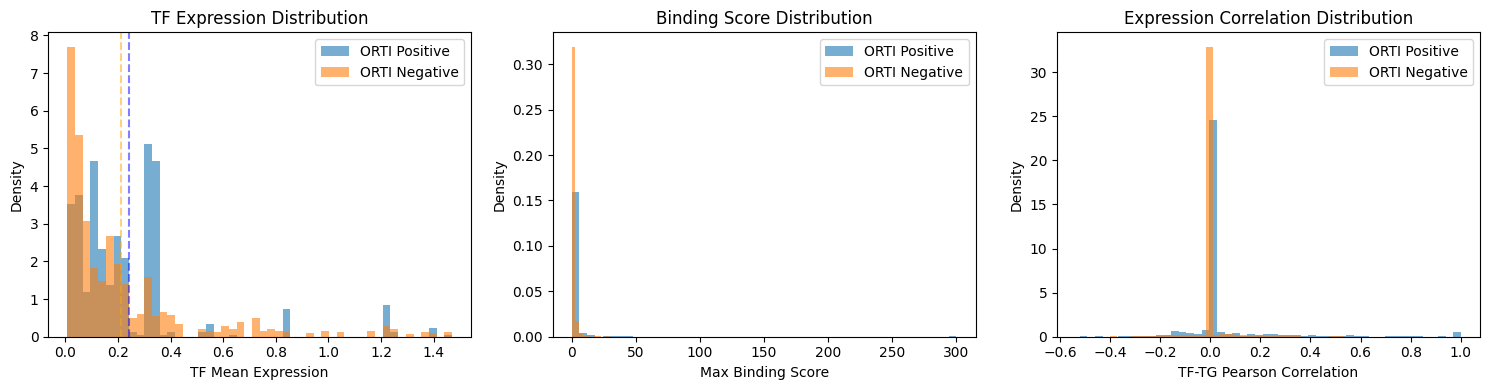


BINDING SCORES IN ORTI EDGES

ORI Positive edges:
  % with any motif (score > 0):     57.8%
  % with p < 0.01 (score > 2):      23.4%
  % with strong motif (score > 5):  6.5%


In [41]:
print("="*80)
print("ORTI GROUND TRUTH ANALYSIS")
print("="*80)

# Check TF expression distribution in ORTI positives vs negatives
orti_positive = test_df[test_df['label'] == 1]
orti_negative = test_df[test_df['label'] == 0]

print(f"\nTF Expression Statistics:")
print(f"  ORTI Positives (n={len(orti_positive):,}):")
print(f"    Mean tf_mean_expr: {orti_positive['tf_mean_expr'].mean():.4f}")
print(f"    Median:            {orti_positive['tf_mean_expr'].median():.4f}")
print(f"    Std:               {orti_positive['tf_mean_expr'].std():.4f}")

print(f"\n  ORTI Negatives (n={len(orti_negative):,}):")
print(f"    Mean tf_mean_expr: {orti_negative['tf_mean_expr'].mean():.4f}")
print(f"    Median:            {orti_negative['tf_mean_expr'].median():.4f}")
print(f"    Std:               {orti_negative['tf_mean_expr'].std():.4f}")

# Effect size
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(orti_positive['tf_mean_expr'], 
                       orti_negative['tf_mean_expr'],
                       alternative='two-sided')

cohens_d = (orti_positive['tf_mean_expr'].mean() - orti_negative['tf_mean_expr'].mean()) / \
           np.sqrt((orti_positive['tf_mean_expr'].std()**2 + orti_negative['tf_mean_expr'].std()**2) / 2)

print(f"\n  Mann-Whitney U test: p = {p:.2e}")
print(f"  Cohen's d (effect size): {cohens_d:.3f}")

# Visualize
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Distribution comparison
axes[0].hist(orti_positive['tf_mean_expr'], bins=50, alpha=0.6, label='ORTI Positive', density=True)
axes[0].hist(orti_negative['tf_mean_expr'], bins=50, alpha=0.6, label='ORTI Negative', density=True)
axes[0].set_xlabel('TF Mean Expression')
axes[0].set_ylabel('Density')
axes[0].set_title('TF Expression Distribution')
axes[0].legend()
axes[0].axvline(orti_positive['tf_mean_expr'].mean(), color='blue', linestyle='--', alpha=0.5)
axes[0].axvline(orti_negative['tf_mean_expr'].mean(), color='orange', linestyle='--', alpha=0.5)

# Check other features too
axes[1].hist(orti_positive['max_binding_score'], bins=50, alpha=0.6, label='ORTI Positive', density=True)
axes[1].hist(orti_negative['max_binding_score'], bins=50, alpha=0.6, label='ORTI Negative', density=True)
axes[1].set_xlabel('Max Binding Score')
axes[1].set_ylabel('Density')
axes[1].set_title('Binding Score Distribution')
axes[1].legend()

axes[2].hist(orti_positive['tf_tg_pearson_corr'], bins=50, alpha=0.6, label='ORTI Positive', density=True)
axes[2].hist(orti_negative['tf_tg_pearson_corr'], bins=50, alpha=0.6, label='ORTI Negative', density=True)
axes[2].set_xlabel('TF-TG Pearson Correlation')
axes[2].set_ylabel('Density')
axes[2].set_title('Expression Correlation Distribution')
axes[2].legend()

plt.tight_layout()
plt.savefig('orti_feature_distributions.png', dpi=300)
plt.show()

# Check how many ORTI edges have low/no binding scores
print(f"\n{'='*80}")
print("BINDING SCORES IN ORTI EDGES")
print(f"{'='*80}")
print(f"\nORI Positive edges:")
print(f"  % with any motif (score > 0):     {(orti_positive['max_binding_score'] > 0).mean()*100:.1f}%")
print(f"  % with p < 0.01 (score > 2):      {(orti_positive['max_binding_score'] > 2).mean()*100:.1f}%")
print(f"  % with strong motif (score > 5):  {(orti_positive['max_binding_score'] > 5).mean()*100:.1f}%")